In [ ]:
from google.colab import drive
drive.mount("/content/gdrive/", force_remount = True)

Mounted at /content/gdrive/


In [ ]:
!pip install pandasql
import os
import calendar
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as sm
import numpy as np
import matplotlib.pyplot as plt
from sqlite3 import connect
from scipy.stats.mstats import winsorize, ks_2samp
from scipy import stats
import seaborn as sns
import pandasql as ps

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26784 sha256=d08b69f610574c584bfc3a02b3bbd8ad221af1c825b7d99f4a25136fe5f56298
  Stored in directory: /root/.cache/pip/wheels/63/e8/ec/75b1df467ecf57b6ececb32cb16f4e86697cbfe55cb0c51f07
Successfully built pandasql


In [ ]:
conn = connect(':memory:', timeout = 10)
filePath = "/content/gdrive/MyDrive/FinancePaperFIMA"

In [ ]:
file = filePath + "/CRSPDaily2015to20220331.csv"
columnsToUse = ['TICKER', 'date', 'SHRCD', 'EXCHCD', 'RET'] ##SHRCD = share code, EXCHCD = exchange code
crsp2015to2022 = pd.read_csv(file, usecols = columnsToUse)[columnsToUse]
print(crsp2015to2022)
print(crsp2015to2022.columns)

<ipython-input-4-9fb261b8f274>:3: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  crsp2015to2022 = pd.read_csv(file, usecols = columnsToUse)[columnsToUse]


         TICKER      date  SHRCD  EXCHCD        RET
0          EGAS  20150102   11.0     2.0   0.000000
1          EGAS  20150105   11.0     2.0   0.000000
2          EGAS  20150106   11.0     2.0  -0.010889
3          EGAS  20150107   11.0     2.0   0.001835
4          EGAS  20150108   11.0     2.0   0.005494
...         ...       ...    ...     ...        ...
13967877   TSLA  20220325   11.0     3.0  -0.003235
13967878   TSLA  20220328   11.0     3.0   0.080345
13967879   TSLA  20220329   11.0     3.0    0.00708
13967880   TSLA  20220330   11.0     3.0  -0.005075
13967881   TSLA  20220331   11.0     3.0  -0.014982

[13967882 rows x 5 columns]
Index(['TICKER', 'date', 'SHRCD', 'EXCHCD', 'RET'], dtype='object')


In [ ]:
#Rename columns
crsp2015to2022.columns = ['tic', 'date', 'shrcd', 'exchcd', 'ret' ]

#Convert Variables
crsp2015to2022['tic'] = crsp2015to2022['tic'].apply(str)
crsp2015to2022['date'] = pd.to_datetime(crsp2015to2022['date'], format = '%Y%m%d')
crsp2015to2022['shrcd'] = pd.to_numeric(crsp2015to2022['shrcd'], errors = 'coerce')
crsp2015to2022['exchcd'] = pd.to_numeric(crsp2015to2022['exchcd'], errors = 'coerce')
crsp2015to2022['ret'] = pd.to_numeric(crsp2015to2022['ret'], errors = 'coerce')

#Only keep dates after 2019
crsp2019to2022 = crsp2015to2022[crsp2015to2022['date'] >= '2019-01-01']

#Only keep US based common stocks
crsp2019to2022 = crsp2019to2022[(crsp2019to2022['shrcd'] == 10) | (crsp2019to2022['shrcd'] == 11)]

#Only keep NYSE/AMEX exchanges
crsp2019to2022 = crsp2019to2022[(crsp2019to2022['exchcd'] == 1) | (crsp2019to2022['exchcd'] == 31) | (crsp2019to2022['exchcd'] == 2) | (crsp2019to2022['exchcd'] == 32)]

#Only keep firms with at least 4 quarters of data
crsp2019to2022 = crsp2019to2022.groupby('tic').filter(lambda x: len(x) >= 252)

#Sort dataframe
crsp2019to2022 = crsp2019to2022.sort_values(by = ['tic', 'date'], ascending = True)

#Drop missing/infinite values
crsp2019to2022.replace([np.inf, -np.inf], np.nan, inplace = True)
crsp2019to2022 = crsp2019to2022.dropna()

#Reindex
crsp2019to2022 = crsp2019to2022.reset_index()
crsp2019to2022.drop('index', inplace = True, axis = 1)

print(crsp2019to2022)
print(crsp2019to2022.columns)

         tic       date  shrcd  exchcd       ret
0          A 2019-01-02   11.0     1.0 -0.026238
1          A 2019-01-03   11.0     1.0 -0.036840
2          A 2019-01-04   11.0     1.0  0.034614
3          A 2019-01-07   11.0     1.0  0.021234
4          A 2019-01-08   11.0     1.0  0.014660
...      ...        ...    ...     ...       ...
1121427  ZUO 2022-03-25   11.0     1.0 -0.026025
1121428  ZUO 2022-03-28   11.0     1.0  0.008016
1121429  ZUO 2022-03-29   11.0     1.0  0.029158
1121430  ZUO 2022-03-30   11.0     1.0 -0.037347
1121431  ZUO 2022-03-31   11.0     1.0  0.002007

[1121432 rows x 5 columns]
Index(['tic', 'date', 'shrcd', 'exchcd', 'ret'], dtype='object')


In [ ]:
# Import Compustat Data
file = filePath + "/Compustat2018Through2022.csv"
compustat2018to2022 = pd.read_csv(file)
print(compustat2018to2022)
print(compustat2018to2022.columns)

<ipython-input-6-56d6a091a9fd>:3: DtypeWarning: Columns (17,18,26,30,647,669,674) have mixed types. Specify dtype option on import or set low_memory=False.
  compustat2018to2022 = pd.read_csv(file)


         gvkey  datadate  fyearq  fqtr  fyr indfmt consol popsrc datafmt  \
0         1004  20180228    2017   3.0    5   INDL      C      D     STD   
1         1004  20180531    2017   4.0    5   INDL      C      D     STD   
2         1004  20180831    2018   1.0    5   INDL      C      D     STD   
3         1004  20181130    2018   2.0    5   INDL      C      D     STD   
4         1004  20190228    2018   3.0    5   INDL      C      D     STD   
...        ...       ...     ...   ...  ...    ...    ...    ...     ...   
190780  351590  20201231    2020   4.0   12   INDL      C      D     STD   
190781  351590  20210331    2021   1.0   12   INDL      C      D     STD   
190782  351590  20210630    2021   2.0   12   INDL      C      D     STD   
190783  351590  20210930    2021   3.0   12   INDL      C      D     STD   
190784  351590  20211231    2021   4.0   12   INDL      C      D     STD   

          tic  ... priusa     sic spcindcd spcseccd  spcsrc  state  stko  \
0         A

In [ ]:
# Clean compustat data

#Parse Relevant Variables
compustat2018to2022 = compustat2018to2022.filter(['tic', 'datadate', 'fyearq', 'fqtr', 'rdq', 'cshoq', 'prccq'])

#Drop missing/infinite values
compustat2018to2022.replace([np.inf, -np.inf], np.nan, inplace = True)
compustat2018to2022 = compustat2018to2022.dropna()

#Convert Variables
compustat2018to2022['tic'] = compustat2018to2022['tic'].apply(str)
compustat2018to2022['datadate'] = pd.to_datetime(compustat2018to2022['datadate'], format = '%Y%m%d')
compustat2018to2022['fyearq'] = pd.to_numeric(compustat2018to2022['fyearq'], errors = 'coerce') #fiscal year @ datadate
compustat2018to2022['fqtr'] = pd.to_numeric(compustat2018to2022['fqtr'], errors = 'coerce') #fiscal quarter
compustat2018to2022['rdq'] = pd.to_datetime(compustat2018to2022['rdq'], format = '%Y%m%d') #quarterly earnings date
compustat2018to2022['cshoq'] = pd.to_numeric(compustat2018to2022['cshoq'], errors = 'coerce') #common shares outstanding
compustat2018to2022['prccq'] = pd.to_numeric(compustat2018to2022['prccq'], errors = 'coerce') #price close - quarter

#Only take dates after 2019
compustat2019to2022 = compustat2018to2022[compustat2018to2022['datadate'] > '2019-01-01']

#Add market value
compustat2019to2022['market_value'] = compustat2019to2022['cshoq'] * compustat2019to2022['prccq']

#Sort dataframe
compustat2019to2022 = compustat2019to2022.sort_values(by = ['tic', 'datadate'], ascending = True)

#Drop missing/infinite values
compustat2019to2022.replace([np.inf, -np.inf], np.nan, inplace = True)
compustat2019to2022 = compustat2019to2022.dropna()

#Drop unneeded columns
compustat2019to2022.drop('cshoq', inplace = True, axis = 1)
compustat2019to2022.drop('prccq', inplace = True, axis = 1)

#Reindex
compustat2019to2022 = compustat2019to2022.reset_index()
compustat2019to2022.drop('index', inplace = True, axis = 1)

print(compustat2019to2022)
print(compustat2019to2022.columns)

         tic   datadate  fyearq  fqtr        rdq  market_value
0          A 2019-01-31    2019   1.0 2019-02-20  24183.900000
1          A 2019-04-30    2019   2.0 2019-05-14  24883.793500
2          A 2019-07-31    2019   3.0 2019-08-14  21489.127770
3          A 2019-10-31    2019   4.0 2019-11-25  23412.128250
4          A 2020-01-31    2020   1.0 2020-02-18  25597.562880
...      ...        ...     ...   ...        ...           ...
86142  ZZZOF 2020-11-30    2020   3.0 2021-01-27      1.939570
86143  ZZZOF 2021-02-28    2020   4.0 2021-06-30      4.848925
86144  ZZZOF 2021-05-31    2021   1.0 2021-07-29      2.134000
86145  ZZZOF 2021-08-31    2021   2.0 2021-10-27      1.358000
86146  ZZZOF 2021-11-30    2021   3.0 2022-01-27      1.008800

[86147 rows x 6 columns]
Index(['tic', 'datadate', 'fyearq', 'fqtr', 'rdq', 'market_value'], dtype='object')


<ipython-input-7-536bb6d239bf>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compustat2019to2022['market_value'] = compustat2019to2022['cshoq'] * compustat2019to2022['prccq']


In [ ]:
# Merge compustat and CRSP

crsp2019to2022.to_sql("crsp2019to2022", conn, if_exists = 'replace')
compustat2019to2022.to_sql("compustat2019to2022", conn, if_exists = 'replace')
query = '''
        SELECT DISTINCT crsp2019to2022.tic, crsp2019to2022.date, crsp2019to2022.ret,
                        compustat2019to2022.datadate, compustat2019to2022.rdq, compustat2019to2022.market_value
        FROM crsp2019to2022
        LEFT JOIN compustat2019to2022
        ON crsp2019to2022.tic = compustat2019to2022.tic
        AND crsp2019to2022.date = compustat2019to2022.rdq
        '''
mainDF = pd.read_sql(query, conn)

#Add calendar year column
mainDF['date'] = pd.to_datetime(mainDF['date'])
mainDF['year'] = mainDF['date'].dt.year

#Add calendar quarter column
mainDF['qtr'] = np.ceil(mainDF['date'].dt.month / 3)

print(mainDF)
print(mainDF.columns)

         tic       date       ret datadate   rdq  market_value  year  qtr
0          A 2019-01-02 -0.026238     None  None           NaN  2019  1.0
1          A 2019-01-03 -0.036840     None  None           NaN  2019  1.0
2          A 2019-01-04  0.034614     None  None           NaN  2019  1.0
3          A 2019-01-07  0.021234     None  None           NaN  2019  1.0
4          A 2019-01-08  0.014660     None  None           NaN  2019  1.0
...      ...        ...       ...      ...   ...           ...   ...  ...
1121284  ZUO 2022-03-25 -0.026025     None  None           NaN  2022  1.0
1121285  ZUO 2022-03-28  0.008016     None  None           NaN  2022  1.0
1121286  ZUO 2022-03-29  0.029158     None  None           NaN  2022  1.0
1121287  ZUO 2022-03-30 -0.037347     None  None           NaN  2022  1.0
1121288  ZUO 2022-03-31  0.002007     None  None           NaN  2022  1.0

[1121289 rows x 8 columns]
Index(['tic', 'date', 'ret', 'datadate', 'rdq', 'market_value', 'year', 'qtr'], dtyp

In [ ]:
# Add size deciles

#Create new dataframe with only RDQ data
dataOnRDQ = mainDF.dropna()

#Take first market value of each year for each firm
marketValueYearStart = dataOnRDQ.groupby(['year', 'tic'], as_index = False)['market_value'].first()

#Add quantile of each firm based on market value
marketValueYearStart['size_quantile'] = marketValueYearStart.groupby(['year'])['market_value'].rank(pct = True)

#Convert quantiles to deciles
marketValueYearStart['size_decile'] = np.ceil(marketValueYearStart['size_quantile'] * 10)

#Merge size deciles back into main dataframe
mainDF.to_sql("mainDF", conn, if_exists = 'replace')
marketValueYearStart.to_sql("marketValueYearStart", conn, if_exists = 'replace')
query = '''
        SELECT DISTINCT mainDF.tic, mainDF.date, mainDF.datadate, mainDF.year, mainDF.qtr,
        mainDF.ret, mainDF.rdq, marketValueYearStart.size_decile
        FROM mainDF
        LEFT JOIN marketValueYearStart
        ON mainDF.tic = marketValueYearStart.tic
        AND mainDF.year = marketValueYearStart.year
        '''
mainDF = pd.read_sql(query, conn)

print(mainDF)
print(mainDF.columns)

         tic                 date datadate  year  qtr       ret   rdq  \
0          A  2019-01-02 00:00:00     None  2019  1.0 -0.026238  None   
1          A  2019-01-03 00:00:00     None  2019  1.0 -0.036840  None   
2          A  2019-01-04 00:00:00     None  2019  1.0  0.034614  None   
3          A  2019-01-07 00:00:00     None  2019  1.0  0.021234  None   
4          A  2019-01-08 00:00:00     None  2019  1.0  0.014660  None   
...      ...                  ...      ...   ...  ...       ...   ...   
1121283  ZUO  2022-03-25 00:00:00     None  2022  1.0 -0.026025  None   
1121284  ZUO  2022-03-28 00:00:00     None  2022  1.0  0.008016  None   
1121285  ZUO  2022-03-29 00:00:00     None  2022  1.0  0.029158  None   
1121286  ZUO  2022-03-30 00:00:00     None  2022  1.0 -0.037347  None   
1121287  ZUO  2022-03-31 00:00:00     None  2022  1.0  0.002007  None   

         size_decile  
0                9.0  
1                9.0  
2                9.0  
3                9.0  
4       

In [ ]:
# Calculate Abnormal Returns
mainDF['date'] = pd.to_datetime(mainDF['date'])
mainDF['size_decile'] = pd.to_numeric(mainDF['size_decile'], errors = 'coerce')
avgRet = mainDF.groupby(['date', 'size_decile'], as_index = False).apply(lambda x: np.average(x['ret']))
avgRet.columns = ['date', 'size_decile', 'avg_ret']

#Merge average returns back into main dataframe
mainDF.to_sql("mainDF", conn, if_exists = 'replace')
avgRet.to_sql("avgRet", conn, if_exists = 'replace')
query = '''
        SELECT DISTINCT mainDF.*, avgRet.avg_ret
        FROM mainDF
        LEFT JOIN avgRet
        ON mainDF.date = avgRet.date
        AND mainDF.size_decile = avgRet.size_decile
        '''
mainDF = pd.read_sql(query, conn)
mainDF.drop('index', inplace = True, axis = 1)

mainDF['ret'] = pd.to_numeric(mainDF['ret'], errors = 'coerce')
mainDF['avg_ret'] = pd.to_numeric(mainDF['avg_ret'], errors = 'coerce')
mainDF['abn_ret'] = mainDF['ret'] - mainDF['avg_ret']

In [ ]:
#Import IBES surprise history data
file = filePath + "/IBESSurpriseHistory.csv"
ibesHistory = pd.read_csv(file)
print(ibesHistory)
print(ibesHistory.columns)

        TICKER OFTIC MEASURE FISCALP  PYEAR  PMON  USFIRM   anndats   actual  \
0         0000  TLMR     EPS     QTR   2014     3       1  20140506    0.120   
1         0000  TLMR     EPS     QTR   2014     6       1  20140806    0.270   
2         0000  TLMR     EPS     QTR   2014     9       1  20141104    0.260   
3         0000  TLMR     EPS     ANN   2014    12       1  20150130    1.210   
4         0000  TLMR     EPS     QTR   2014    12       1  20150130    0.160   
...        ...   ...     ...     ...    ...   ...     ...       ...      ...   
1423206   ZYNX  ZYXI     SAL     QTR   2021     3       1  20210429   24.127   
1423207   ZYNX  ZYXI     SAL     QTR   2021     6       1  20210729   31.022   
1423208   ZYNX  ZYXI     SAL     QTR   2021     9       1  20211102   34.786   
1423209   ZYNX  ZYXI     SAL     ANN   2021    12       1  20220224  130.301   
1423210   ZYNX  ZYXI     SAL     QTR   2021    12       1  20220224   40.366   

          surpmean  surpstdev  suescore

In [ ]:
#Clean data
ibesHistory['PYEAR'] = pd.to_numeric(ibesHistory['PYEAR'], errors = 'coerce')
ibesHistory['PMON'] = pd.to_numeric(ibesHistory['PMON'], errors = 'coerce')
ibes2019to2022 = ibesHistory[ibesHistory['PYEAR'] >= 2019]

#Only keep quarterly date
ibes2019to2022 = ibes2019to2022[ibes2019to2022['FISCALP'] == 'QTR']

#Only keep EPS data
ibes2019to2022 = ibes2019to2022[ibes2019to2022['MEASURE'] == 'EPS']

#Reindex
ibes2019to2022 = ibes2019to2022.reset_index()
ibes2019to2022.drop('index', inplace = True, axis = 1)

#Add datadate of each row
ibes2019to2022['PDAY'] = 1
ibes2019to2022['datadate'] = pd.to_datetime((10000 * ibes2019to2022['PYEAR'] + 100 * ibes2019to2022['PMON'] + ibes2019to2022['PDAY']).apply(str), format = '%Y%m%d')
ibes2019to2022['datadate'] = pd.to_datetime((10000 * ibes2019to2022['PYEAR'] + 100 * ibes2019to2022['PMON'] + ibes2019to2022['datadate'].dt.days_in_month).apply(str), format = '%Y%m%d')

#Parse relevant columns
ibes2019to2022 = ibes2019to2022.filter(['OFTIC', 'PYEAR', 'PMON', 'suescore', 'datadate'])
ibes2019to2022.columns = ['tic', 'year', 'month', 'sue', 'datadate']

#Drio missing/inf values
ibes2019to2022.replace([np.inf, -np.inf], np.nan, inplace = True)
ibes2019to2022 = ibes2019to2022.dropna()

#sort dataframe
ibes2019to2022 = ibes2019to2022.sort_values(by = ['tic', 'datadate'], ascending = True)

#Reindex
ibes2019to2022 = ibes2019to2022.reset_index()
ibes2019to2022.drop('index', inplace = True, axis = 1)

print(ibes2019to2022)
print(ibes2019to2022.columns)

        tic  year  month      sue   datadate
0         A  2019      1  2.91543 2019-01-31
1         A  2019      4 -0.61391 2019-04-30
2         A  2019      7  4.67368 2019-07-31
3         A  2019     10  4.55811 2019-10-31
4         A  2020      1  0.07880 2020-01-31
...     ...   ...    ...      ...        ...
43374  ZYXI  2020     12 -0.68286 2020-12-31
43375  ZYXI  2021      3  0.44723 2021-03-31
43376  ZYXI  2021      6  1.56530 2021-06-30
43377  ZYXI  2021      9  1.55065 2021-09-30
43378  ZYXI  2021     12  1.48519 2021-12-31

[43379 rows x 5 columns]
Index(['tic', 'year', 'month', 'sue', 'datadate'], dtype='object')


In [ ]:
#Merge sue into main df
mainDF.to_sql("mainDF", conn, if_exists = 'replace')
ibes2019to2022.to_sql("ibes2019to2022", conn, if_exists = 'replace')
query = '''
        SELECT DISTINCT mainDF.*, ibes2019to2022.sue
        FROM mainDF
        LEFT JOIN ibes2019to2022
        ON mainDF.tic = ibes2019to2022.tic
        AND mainDF.datadate = ibes2019to2022.datadate
        '''
mainDF = pd.read_sql(query, conn)
mainDF.drop('index', inplace = True, axis = 1)

print(mainDF)
print(mainDF.columns)

         tic                 date datadate  year  qtr       ret   rdq  \
0          A  2019-01-02 00:00:00     None  2019  1.0 -0.026238  None   
1          A  2019-01-03 00:00:00     None  2019  1.0 -0.036840  None   
2          A  2019-01-04 00:00:00     None  2019  1.0  0.034614  None   
3          A  2019-01-07 00:00:00     None  2019  1.0  0.021234  None   
4          A  2019-01-08 00:00:00     None  2019  1.0  0.014660  None   
...      ...                  ...      ...   ...  ...       ...   ...   
1121283  ZUO  2022-03-25 00:00:00     None  2022  1.0 -0.026025  None   
1121284  ZUO  2022-03-28 00:00:00     None  2022  1.0  0.008016  None   
1121285  ZUO  2022-03-29 00:00:00     None  2022  1.0  0.029158  None   
1121286  ZUO  2022-03-30 00:00:00     None  2022  1.0 -0.037347  None   
1121287  ZUO  2022-03-31 00:00:00     None  2022  1.0  0.002007  None   

         size_decile   avg_ret   abn_ret  sue  
0                9.0 -0.001194 -0.025044  NaN  
1                9.0 -0.015

In [ ]:
# Add SUE deciles

#Filter for only data on RDQ (report date quarterly earnings)
dataOnRDQ = mainDF.dropna()

#Take unique year and quarter to decrease runtime
dataOnRDQ.to_sql("dataOnRDQ", conn, if_exists = 'replace')
query = '''
        SELECT DISTINCT year, qtr
        FROM dataOnRDQ
        '''
sueDeciles = pd.read_sql(query, conn)

#Generate new df with quantiles of each quarter
for i in range(1, 10):
  currentDecile = dataOnRDQ.groupby(['year', 'qtr'])['sue'].quantile(i/10)
  sueDeciles['prior_quarter_sue_decile' + str(i)] = ""
  for j in sueDeciles.index:
    sueDeciles['prior_quarter_sue_decile' + str(i)][j] = currentDecile[sueDeciles['year'][j], sueDeciles['qtr'][j]]
  sueDeciles['prior_quarter_sue_decile' + str(i)] = sueDeciles['prior_quarter_sue_decile' + str(i)].shift(1)
  sueDeciles['prior_quarter_sue_decile' + str(i)] = pd.to_numeric(sueDeciles['prior_quarter_sue_decile' + str(i)], errors = 'coerce')

#Merge sue quantiles back into
dataOnRDQ.to_sql("dataOnRDQ", conn, if_exists = 'replace')
sueDeciles.to_sql("sueDeciles", conn, if_exists = 'replace')
query = '''
        SELECT DISTINCT dataOnRDQ.*, sueDeciles.prior_quarter_sue_decile1, sueDeciles.prior_quarter_sue_decile2, sueDeciles.prior_quarter_sue_decile3,
        sueDeciles.prior_quarter_sue_decile4, sueDeciles.prior_quarter_sue_decile5, sueDeciles.prior_quarter_sue_decile6,
        sueDeciles.prior_quarter_sue_decile7, sueDeciles.prior_quarter_sue_decile8, sueDeciles.prior_quarter_sue_decile9
        FROM dataOnRDQ
        LEFT JOIN sueDeciles
        ON dataOnRDQ.year = sueDeciles.year
        AND dataOnRDQ.qtr = sueDeciles.qtr
        '''
dataOnRDQ = pd.read_sql(query, conn)

#Drop index columns
dataOnRDQ.drop('index', inplace = True, axis = 1)

#Drop first quarter data of every firm
dataOnRDQ = dataOnRDQ.dropna()

#Drop 2nd quarter of overall data (insufficient sample size in 2019Q1)
dataOnRDQ = dataOnRDQ[(dataOnRDQ['year'] != 2019) | (dataOnRDQ['qtr'] != 2)]

#Reindex
dataOnRDQ = dataOnRDQ.reset_index()
dataOnRDQ.drop('index', inplace = True, axis = 1)

<ipython-input-14-b2433a9e6db7>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sueDeciles['prior_quarter_sue_decile' + str(i)][j] = currentDecile[sueDeciles['year'][j], sueDeciles['qtr'][j]]
<ipython-input-14-b2433a9e6db7>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sueDeciles['prior_quarter_sue_decile' + str(i)][j] = currentDecile[sueDeciles['year'][j], sueDeciles['qtr'][j]]
<ipython-input-14-b2433a9e6db7>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

In [ ]:
#Add sue decile to every row
dataOnRDQ['sue_decile'] = ""
dataOnRDQ['sue'] = pd.to_numeric(dataOnRDQ['sue'], errors = 'coerce')
for i in dataOnRDQ.index:
  if dataOnRDQ['sue'][i] <= dataOnRDQ['prior_quarter_sue_decile1'][i]:
    dataOnRDQ['sue_decile'][i] = 1
  elif dataOnRDQ['prior_quarter_sue_decile1'][i] < dataOnRDQ['sue'][i] <= dataOnRDQ['prior_quarter_sue_decile2'][i]:
    dataOnRDQ['sue_decile'][i] = 2
  elif dataOnRDQ['prior_quarter_sue_decile2'][i] < dataOnRDQ['sue'][i] <= dataOnRDQ['prior_quarter_sue_decile3'][i]:
    dataOnRDQ['sue_decile'][i] = 3
  elif dataOnRDQ['prior_quarter_sue_decile3'][i] < dataOnRDQ['sue'][i] <= dataOnRDQ['prior_quarter_sue_decile4'][i]:
    dataOnRDQ['sue_decile'][i] = 4
  elif dataOnRDQ['prior_quarter_sue_decile4'][i] < dataOnRDQ['sue'][i] <= dataOnRDQ['prior_quarter_sue_decile5'][i]:
    dataOnRDQ['sue_decile'][i] = 5
  elif dataOnRDQ['prior_quarter_sue_decile5'][i] < dataOnRDQ['sue'][i] <= dataOnRDQ['prior_quarter_sue_decile6'][i]:
    dataOnRDQ['sue_decile'][i] = 6
  elif dataOnRDQ['prior_quarter_sue_decile6'][i] < dataOnRDQ['sue'][i] <= dataOnRDQ['prior_quarter_sue_decile7'][i]:
    dataOnRDQ['sue_decile'][i] = 7
  elif dataOnRDQ['prior_quarter_sue_decile7'][i] < dataOnRDQ['sue'][i] <= dataOnRDQ['prior_quarter_sue_decile8'][i]:
    dataOnRDQ['sue_decile'][i] = 8
  elif dataOnRDQ['prior_quarter_sue_decile8'][i] < dataOnRDQ['sue'][i] <= dataOnRDQ['prior_quarter_sue_decile9'][i]:
    dataOnRDQ['sue_decile'][i] = 9
  elif dataOnRDQ['sue'][i] > dataOnRDQ['prior_quarter_sue_decile9'][i]:
    dataOnRDQ['sue_decile'][i] = 10
  else:
    print("Error at row" + str(i))
    break

#Drop decile values
toDrop = []
for i in range(1,10):
  toDrop.append('prior_quarter_sue_decile' + str(i))
dataOnRDQ.drop(toDrop, inplace = True, axis = 1)


<ipython-input-15-b084f8292b47>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataOnRDQ['sue_decile'][i] = 9
<ipython-input-15-b084f8292b47>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataOnRDQ['sue_decile'][i] = 4
<ipython-input-15-b084f8292b47>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataOnRDQ['sue_decile'][i] = 6
<ipython-input-15-b084f8292b47>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy o

In [ ]:
#Merge sue decile into mainDF
mainDF.to_sql("mainDF", conn, if_exists = 'replace')
dataOnRDQ.to_sql("dataOnRDQ", conn, if_exists = 'replace')
query = '''
        SELECT DISTINCT mainDF.*, dataOnRDQ.sue_decile
        FROM mainDF
        LEFT JOIN dataOnRDQ
        ON mainDF.tic = dataOnRDQ.tic
        AND mainDF.year = dataOnRDQ.year
        AND mainDF.qtr = dataOnRDQ.qtr
        '''
mainDF = pd.read_sql(query, conn)

#Drop index columns
mainDF.drop('index', inplace = True, axis = 1)

#Convert variable
mainDF['date'] = pd.to_datetime(mainDF['date'])
mainDF['datadate'] = pd.to_datetime(mainDF['datadate'], errors = 'coerce')
mainDF['rdq'] = pd.to_datetime(mainDF['rdq'], errors = 'coerce')
mainDF['tic'] = mainDF['tic'].apply(str)

#Only keep one row of data per tic and date
mainDF = mainDF.groupby(['tic', 'date'], as_index = False)
mainDF = mainDF.first()

print(mainDF)
print(mainDF.columns)

         tic       date datadate  year  qtr       ret rdq  size_decile  \
0          A 2019-01-02      NaT  2019  1.0 -0.026238 NaT          9.0   
1          A 2019-01-03      NaT  2019  1.0 -0.036840 NaT          9.0   
2          A 2019-01-04      NaT  2019  1.0  0.034614 NaT          9.0   
3          A 2019-01-07      NaT  2019  1.0  0.021234 NaT          9.0   
4          A 2019-01-08      NaT  2019  1.0  0.014660 NaT          9.0   
...      ...        ...      ...   ...  ...       ...  ..          ...   
1107138  ZUO 2022-03-25      NaT  2022  1.0 -0.026025 NaT          4.0   
1107139  ZUO 2022-03-28      NaT  2022  1.0  0.008016 NaT          4.0   
1107140  ZUO 2022-03-29      NaT  2022  1.0  0.029158 NaT          4.0   
1107141  ZUO 2022-03-30      NaT  2022  1.0 -0.037347 NaT          4.0   
1107142  ZUO 2022-03-31      NaT  2022  1.0  0.002007 NaT          4.0   

          avg_ret   abn_ret  sue  sue_decile  
0       -0.001194 -0.025044  NaN         NaN  
1       -0.015902

In [ ]:
## ALL FIRMS: Calculate Cumulative abnormal returns for every RDQ

#Store mainDF for future use
originalMain = mainDF
mainDF = originalMain

#Generate new dataframe with tic, sue decile, and size decile on RDQ
TicOfRDQ = mainDF.dropna()
TicOfRDQ = TicOfRDQ.filter(['tic', 'sue_decile', 'size_decile'])

#Generate new groupby variable of abnormal return with tic and original_index as indices
abnRet = mainDF.reset_index()
abnRet.columns = ['original_index', 'tic', 'date', 'datadate', 'year', 'qtr', 'ret', 'rdq', 'size_decile', 'avg_ret', 'abn_ret', 'sue', 'sue_decile']
abnRet = abnRet.groupby(['tic', 'original_index'], as_index = False)['abn_ret'].first()
abnRet['new_index'] = abnRet['tic'].apply(str) + "/" + abnRet['original_index'].apply(str)
abnRet = abnRet.set_index('new_index')

#Create new array to store CAR around RDQ
carArrayBeforeAll = []
carArrayAfterAll = []
for i in range(11):
  carArrayBeforeAll.append([])
  carArrayAfterAll.append([])

#Caculate CAR and store them in corresponding SUE deciles
n = 60
for rdqDate in TicOfRDQ.index:
  #Generate indices for abnormal return dataframe
  nDaysBeforeIndex = str(TicOfRDQ['tic'][rdqDate]) + "/" + str(rdqDate - n)
  rdqDateIndex = str(TicOfRDQ['tic'][rdqDate]) + "/" + str(rdqDate)
  nDaysAfterIndex = str(TicOfRDQ['tic'][rdqDate]) + "/" + str(rdqDate + n)
  if (nDaysBeforeIndex in abnRet.index) and (nDaysAfterIndex in abnRet.index): #check if n days before and after RDQ abnormal return data exist
    #Add n days before CAR
    beforeDF = pd.DataFrame(abnRet.loc[nDaysBeforeIndex : rdqDateIndex]).reset_index()
    beforeDF['car'] = beforeDF['abn_ret'].cumsum() - beforeDF['abn_ret'][0]
    carArrayBeforeAll[TicOfRDQ['sue_decile'][rdqDate].astype(int)].append(beforeDF['car'])
    #Add n days after CAR
    afterDF = pd.DataFrame(abnRet.loc[rdqDateIndex : nDaysAfterIndex]).reset_index()
    afterDF['car'] = afterDF['abn_ret'].cumsum() - afterDF['abn_ret'][0]
    carArrayAfterAll[TicOfRDQ['sue_decile'][rdqDate].astype(int)].append(afterDF['car'])

In [ ]:
## ALL FIRMS: Generate New CAR Arrays for each decile and each day ##

#Create new array to store CAR data on each day before RDQ
carAllByDaysBefore = []
#Set up empty array
for i in range(11):
  carAllByDaysBefore.append([])
  for j in range(61):
    carAllByDaysBefore[i].append([])

#Add CAR data
for i in range(len(carArrayBeforeAll)):
  for j in range(len(carArrayBeforeAll[i])):
    for k in range(len(carAllByDaysBefore[i])):
      carAllByDaysBefore[i][k].append(carArrayBeforeAll[i][j][k])

#Create new array to store CAR data on each day after RDQ
carAllByDaysAfter = []
for i in range(11):
  carAllByDaysAfter.append([])
  for j in range(61):
    carAllByDaysAfter[i].append([])

#Add CAR data
for i in range(len(carArrayAfterAll)):
  for j in range(len(carArrayAfterAll[i])):
    for k in range(len(carAllByDaysAfter[i])):
      carAllByDaysAfter[i][k].append(carArrayAfterAll[i][j][k])


In [ ]:
## ALL FIRMS: Generate dataframe with average CAR for each day before RDQ

#New DF to store data
avgCARAllBefore = pd.DataFrame()
for i in range(1, 11):
  avgCARAllBefore['decile_' + str(i)] = 100 * pd.DataFrame(carAllByDaysBefore[i]).mean(axis = 1) # *100 for avg % CAR

#Add column to store days relative to RDQ
avgCARAllBefore = avgCARAllBefore.reset_index()
avgCARAllBefore = avgCARAllBefore.rename(columns = {'index' : 'days_relative_to_rdq'})

#Make days relative to RDQ in range [-60, 0] since data is before RDQ
avgCARAllBefore['days_relative_to_rdq'] = pd.to_numeric(avgCARAllBefore['days_relative_to_rdq'], errors = 'coerce')
avgCARAllBefore['days_relative_to_rdq'] -= 60 ## ????? idk what

print(avgCARAllBefore)
print(avgCARAllBefore.columns)

    days_relative_to_rdq  decile_1  decile_2  decile_3  decile_4  decile_5  \
0                    -60  0.000000  0.000000  0.000000  0.000000  0.000000   
1                    -59 -0.032265  0.041331  0.109014 -0.012663  0.105149   
2                    -58 -0.081745 -0.045392 -0.061688 -0.058010  0.222701   
3                    -57 -0.160471  0.125799 -0.203450 -0.045370  0.256293   
4                    -56 -0.318694  0.163423 -0.257944 -0.083663  0.263284   
..                   ...       ...       ...       ...       ...       ...   
56                    -4 -1.568051 -1.249724 -1.686392 -1.527070  0.894858   
57                    -3 -1.750371 -1.488610 -1.875527 -1.631404  1.033913   
58                    -2 -1.769042 -1.411614 -2.157912 -1.554892  1.049473   
59                    -1 -1.715537 -1.486227 -2.013908 -1.574204  1.156539   
60                     0 -3.695478 -2.670704 -3.079963 -1.674057  1.626211   

    decile_6  decile_7  decile_8  decile_9  decile_10  
0   0.0

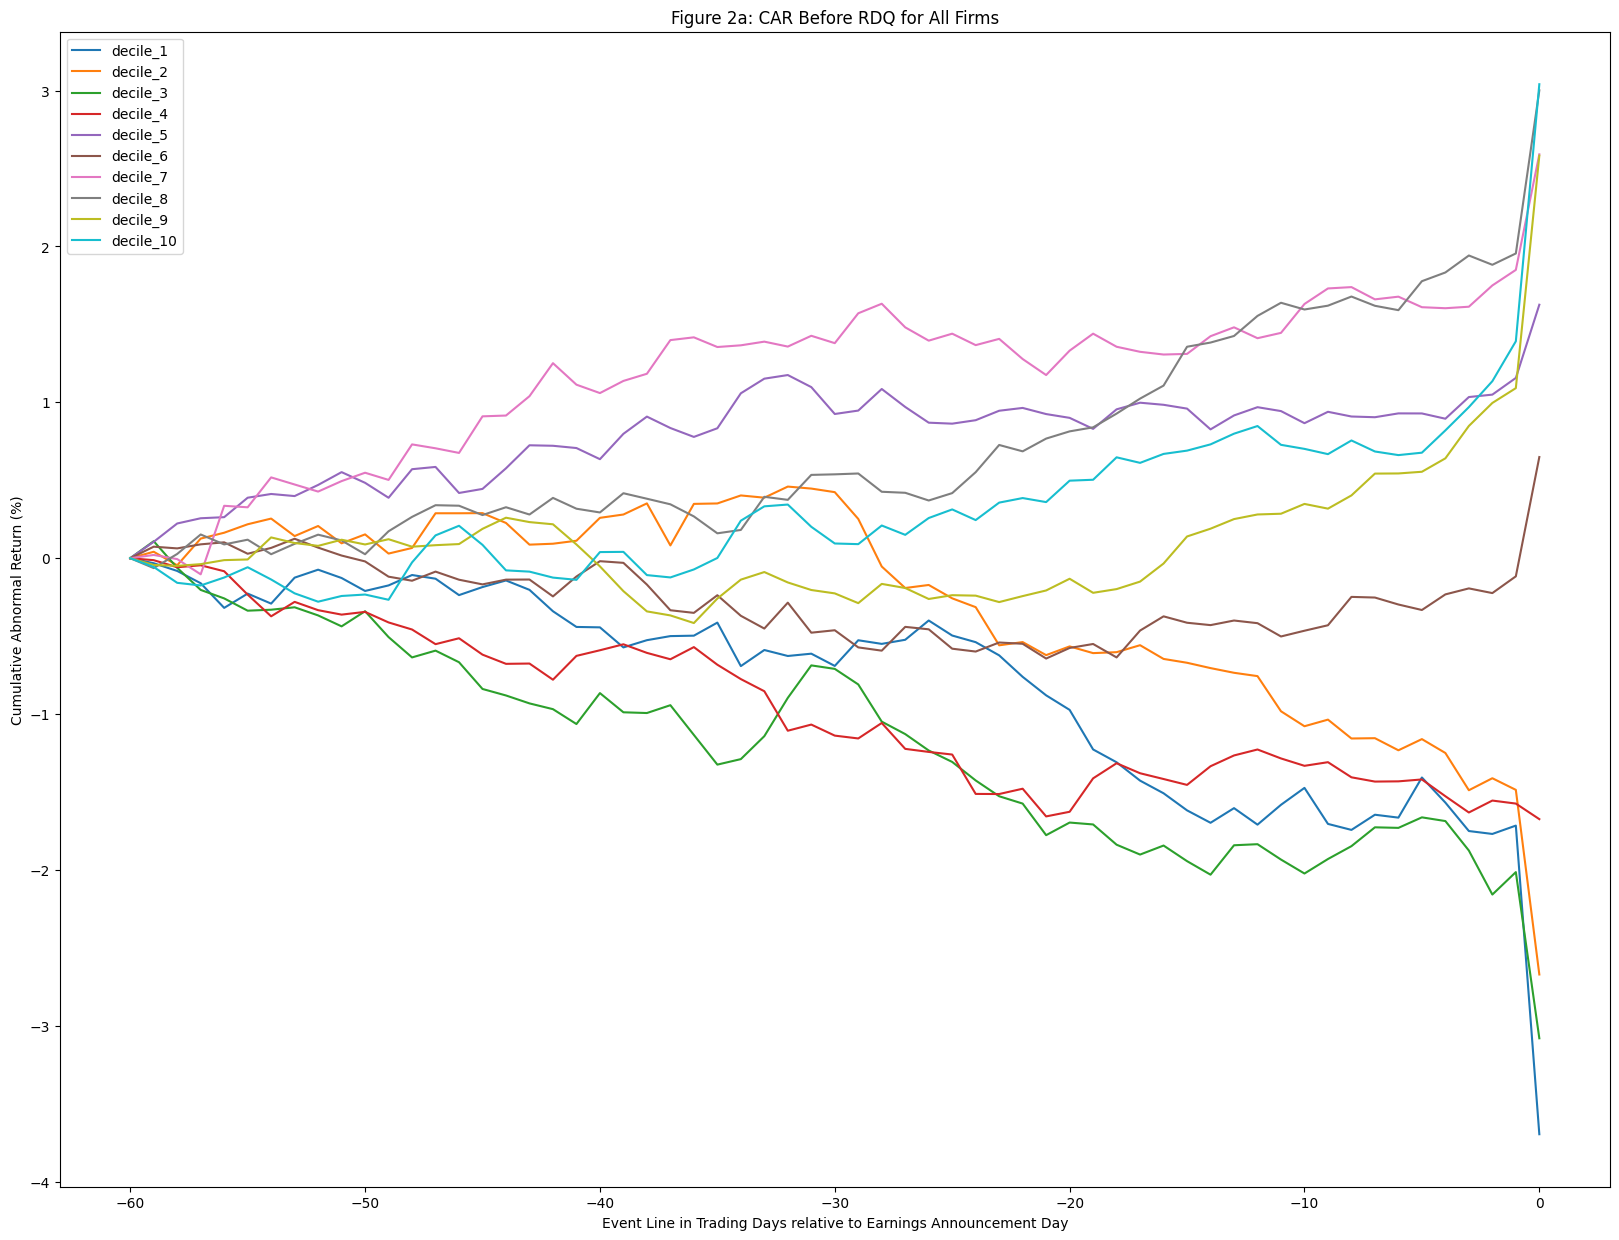

In [ ]:
##ALL FIRMS: Generate and Save Figure 2 Before RDQ

#plot graph in python
allFirmsBeforeRDQ = avgCARAllBefore.plot(x = 'days_relative_to_rdq', y = ['decile_1', 'decile_2', 'decile_3', 'decile_4', 'decile_5', 'decile_6', 'decile_7', 'decile_8', 'decile_9', 'decile_10'], kind = "line", figsize=[20,15], title = "Figure 2a: CAR Before RDQ for All Firms")
allFirmsBeforeRDQ.set_xlabel("Event Line in Trading Days relative to Earnings Announcement Day")
allFirmsBeforeRDQ.set_ylabel("Cumulative Abnormal Return (%)")

#Save graph in google drive folder
fig = allFirmsBeforeRDQ.get_figure()
fig.savefig(filePath + "/allFirmsBeforeRDQ.png")

In [ ]:
## ALL FIRMS: Generate dataframe with average CAR for each day AFTER RDQ

#New DF to store data
avgCARAllAfter = pd.DataFrame()
for i in range(1, 11):
  avgCARAllAfter['decile_' + str(i)] = 100 * pd.DataFrame(carAllByDaysAfter[i]).mean(axis = 1) # *100 for avg % CAR

#Add column to store days relative to RDQ
avgCARAllAfter = avgCARAllAfter.reset_index()
avgCARAllAfter = avgCARAllAfter.rename(columns = {'index' : 'days_relative_to_rdq'})

#Make days relative to RDQ in range [-60, 0] since data is before RDQ
avgCARAllAfter['days_relative_to_rdq'] = pd.to_numeric(avgCARAllAfter['days_relative_to_rdq'], errors = 'coerce')

print(avgCARAllAfter)
print(avgCARAllAfter.columns)

    days_relative_to_rdq  decile_1  decile_2  decile_3  decile_4  decile_5  \
0                      0  0.000000  0.000000  0.000000  0.000000  0.000000   
1                      1 -2.183261 -1.430634 -1.058123  0.048887  0.060333   
2                      2 -2.200740 -1.445782 -1.176919  0.027433  0.026823   
3                      3 -2.058723 -1.447307 -1.347030  0.062261 -0.005762   
4                      4 -2.029053 -1.440709 -1.454460  0.066210 -0.122970   
..                   ...       ...       ...       ...       ...       ...   
56                    56 -2.242126 -1.418102 -0.388293  0.234788  0.788499   
57                    57 -2.477896 -1.307799 -0.391807  0.380279  0.895517   
58                    58 -2.015005 -1.327772 -0.492062  0.504289  0.941042   
59                    59 -2.137091 -1.150389 -0.461763  0.421818  0.951362   
60                    60 -1.994887 -1.054348 -0.561888  0.340590  0.945902   

    decile_6  decile_7  decile_8  decile_9  decile_10  
0   0.0

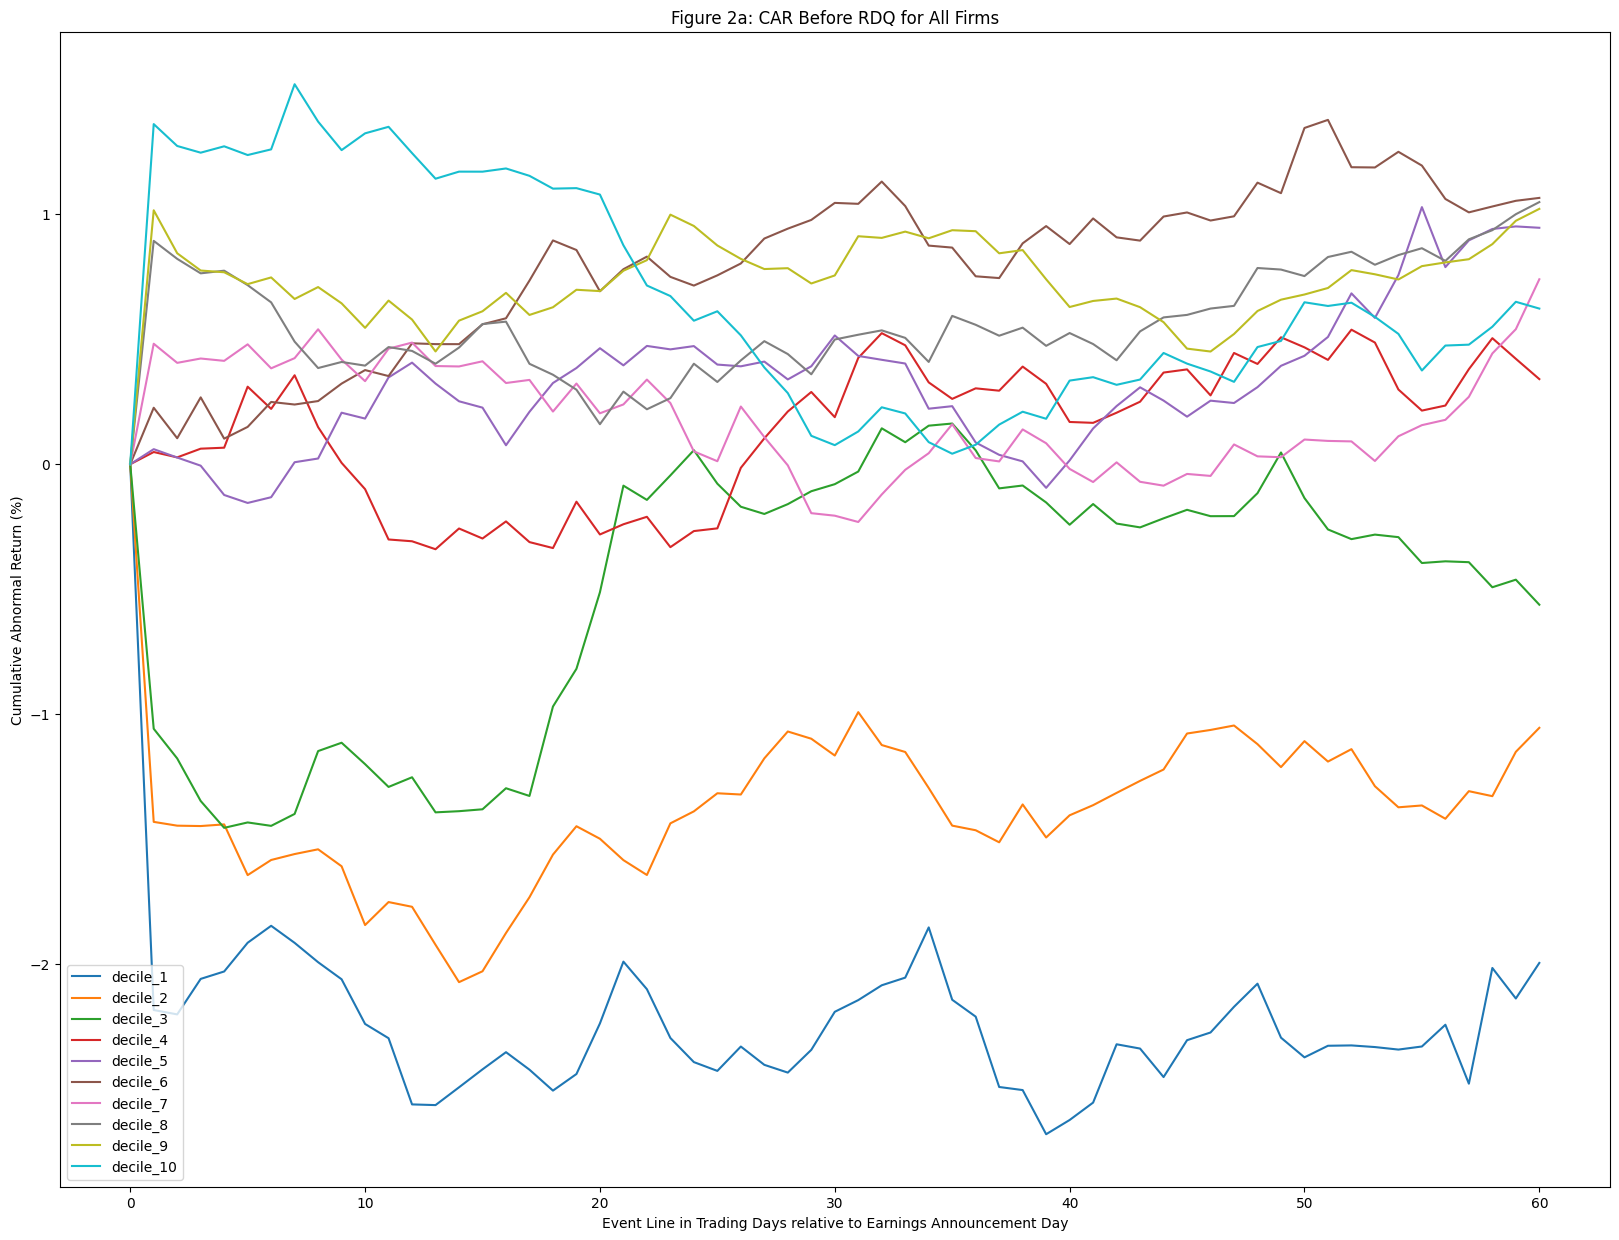

In [ ]:
##ALL FIRMS: Generate and Save Figure 2 AFTER RDQ

#plot graph in python
allFirmsAfterRDQ = avgCARAllAfter.plot(x = 'days_relative_to_rdq', y = ['decile_1', 'decile_2', 'decile_3', 'decile_4', 'decile_5', 'decile_6', 'decile_7', 'decile_8', 'decile_9', 'decile_10'], kind = "line", figsize=[20,15], title = "Figure 2a: CAR Before RDQ for All Firms")
allFirmsAfterRDQ.set_xlabel("Event Line in Trading Days relative to Earnings Announcement Day")
allFirmsAfterRDQ.set_ylabel("Cumulative Abnormal Return (%)")

#Save graph in google drive folder
fig = allFirmsAfterRDQ.get_figure()
fig.savefig(filePath + "/allFirmsAfterRDQ.png")

In [ ]:
## BIG FIRMS: Calculate Cumulative abnormal returns for every RDQ

#
#
# Block is weird... screws up all the firm size stuff
#
#
#
#Store mainDF for future use
mainDF = originalMain

#Only keep big firms

mainDF = mainDF[mainDF['size_decile'] >= 8]
mainDF = mainDF.reset_index()
mainDF.drop('index', inplace = True, axis = 1)

#Generate new dataframe with tic, sue decile, and size decile on RDQ
TicOfRDQBig = mainDF.dropna()
TicOfRDQBig = TicOfRDQBig.filter(['tic', 'sue_decile', 'size_decile'])


#Generate new groupby variable of abnormal return with tic and original_index as indices
abnRetBig = mainDF.reset_index()
abnRetBig.columns = ['original_index', 'tic', 'date', 'datadate', 'year', 'qtr', 'ret', 'rdq', 'size_decile', 'avg_ret', 'abn_ret', 'sue', 'sue_decile']
abnRetBig = abnRetBig.groupby(['tic', 'original_index'], as_index = False)['abn_ret'].first()
abnRetBig['new_index'] = abnRetBig['tic'].apply(str) + "/" + abnRetBig['original_index'].apply(str)
abnRetBig = abnRetBig.set_index('new_index')


#Create new array to store CAR around RDQ
carArrayBeforeBig = []
carArrayAfterBig = []
for i in range(11):
 carArrayBeforeBig.append([])
 carArrayAfterBig.append([])


#Caculate CAR and store them in corresponding SUE deciles
n = 60
for rdqDate in TicOfRDQBig.index:
 #Generate indices for abnormal return dataframe
 nDaysBeforeIndex = str(TicOfRDQBig['tic'][rdqDate]) + "/" + str(rdqDate - n)
 rdqDateIndex = str(TicOfRDQBig['tic'][rdqDate]) + "/" + str(rdqDate)
 nDaysAfterIndex = str(TicOfRDQBig['tic'][rdqDate]) + "/" + str(rdqDate + n)
 if (nDaysBeforeIndex in abnRetBig.index) and (nDaysAfterIndex in abnRetBig.index): #check if n days before and after RDQ abnormal return data exist
   #Add n days before CAR
   beforeDF = pd.DataFrame(abnRetBig.loc[nDaysBeforeIndex : rdqDateIndex]).reset_index()
   beforeDF['car'] = beforeDF['abn_ret'].cumsum() - beforeDF['abn_ret'][0]
   carArrayBeforeBig[TicOfRDQBig['sue_decile'][rdqDate].astype(int)].append(beforeDF['car'])
   #Add n days after CAR
   afterDF = pd.DataFrame(abnRetBig.loc[rdqDateIndex : nDaysAfterIndex]).reset_index()
   afterDF['car'] = afterDF['abn_ret'].cumsum() - afterDF['abn_ret'][0]
   carArrayAfterBig[TicOfRDQBig['sue_decile'][rdqDate].astype(int)].append(afterDF['car'])



NameError: ignored

In [ ]:
### BIG FIRMS: Generate New CAR Arrays for each decile and each day ##


#Create new array to store CAR data on each day before RDQ
carBigByDaysBefore = []
#Set up empty array
for i in range(11):
 carBigByDaysBefore.append([])
 for j in range(61):
   carBigByDaysBefore[i].append([])


#Add CAR data
for i in range(len(carArrayBeforeBig)):
 for j in range(len(carArrayBeforeBig[i])):
   for k in range(len(carBigByDaysBefore[i])):
     carBigByDaysBefore[i][k].append(carArrayBeforeBig[i][j][k])


#Create new array to store CAR data on each day after RDQ
carBigByDaysAfter = []
for i in range(11):
 carBigByDaysAfter.append([])
 for j in range(61):
   carBigByDaysAfter[i].append([])


#Add CAR data
for i in range(len(carArrayAfterBig)):
 for j in range(len(carArrayAfterBig[i])):
   for k in range(len(carBigByDaysAfter[i])):
     carBigByDaysAfter[i][k].append(carArrayAfterBig[i][j][k])


    days_relative_to_rdq  decile_1  decile_2  decile_3  decile_4  decile_5  \
0                    -60  0.000000  0.000000  0.000000  0.000000  0.000000   
1                    -59 -0.144558  0.214233 -0.224007 -0.028735 -0.080776   
2                    -58 -0.111612  0.226820 -0.388867  0.041386 -0.138722   
3                    -57  0.025634  0.239595 -0.570619  0.040705 -0.123202   
4                    -56 -0.344848  0.341314 -0.705055 -0.004528 -0.184162   
..                   ...       ...       ...       ...       ...       ...   
56                    -4 -3.186246 -2.954747 -1.894795 -1.548577 -0.227870   
57                    -3 -3.507405 -3.380285 -2.085174 -1.666427 -0.171170   
58                    -2 -3.522450 -3.533400 -2.162095 -1.751442 -0.295246   
59                    -1 -3.520784 -3.775586 -2.097325 -1.706739 -0.272081   
60                     0 -5.286066 -4.993806 -3.266985 -2.064834 -0.297192   

    decile_6  decile_7  decile_8  decile_9  decile_10  
0   0.0

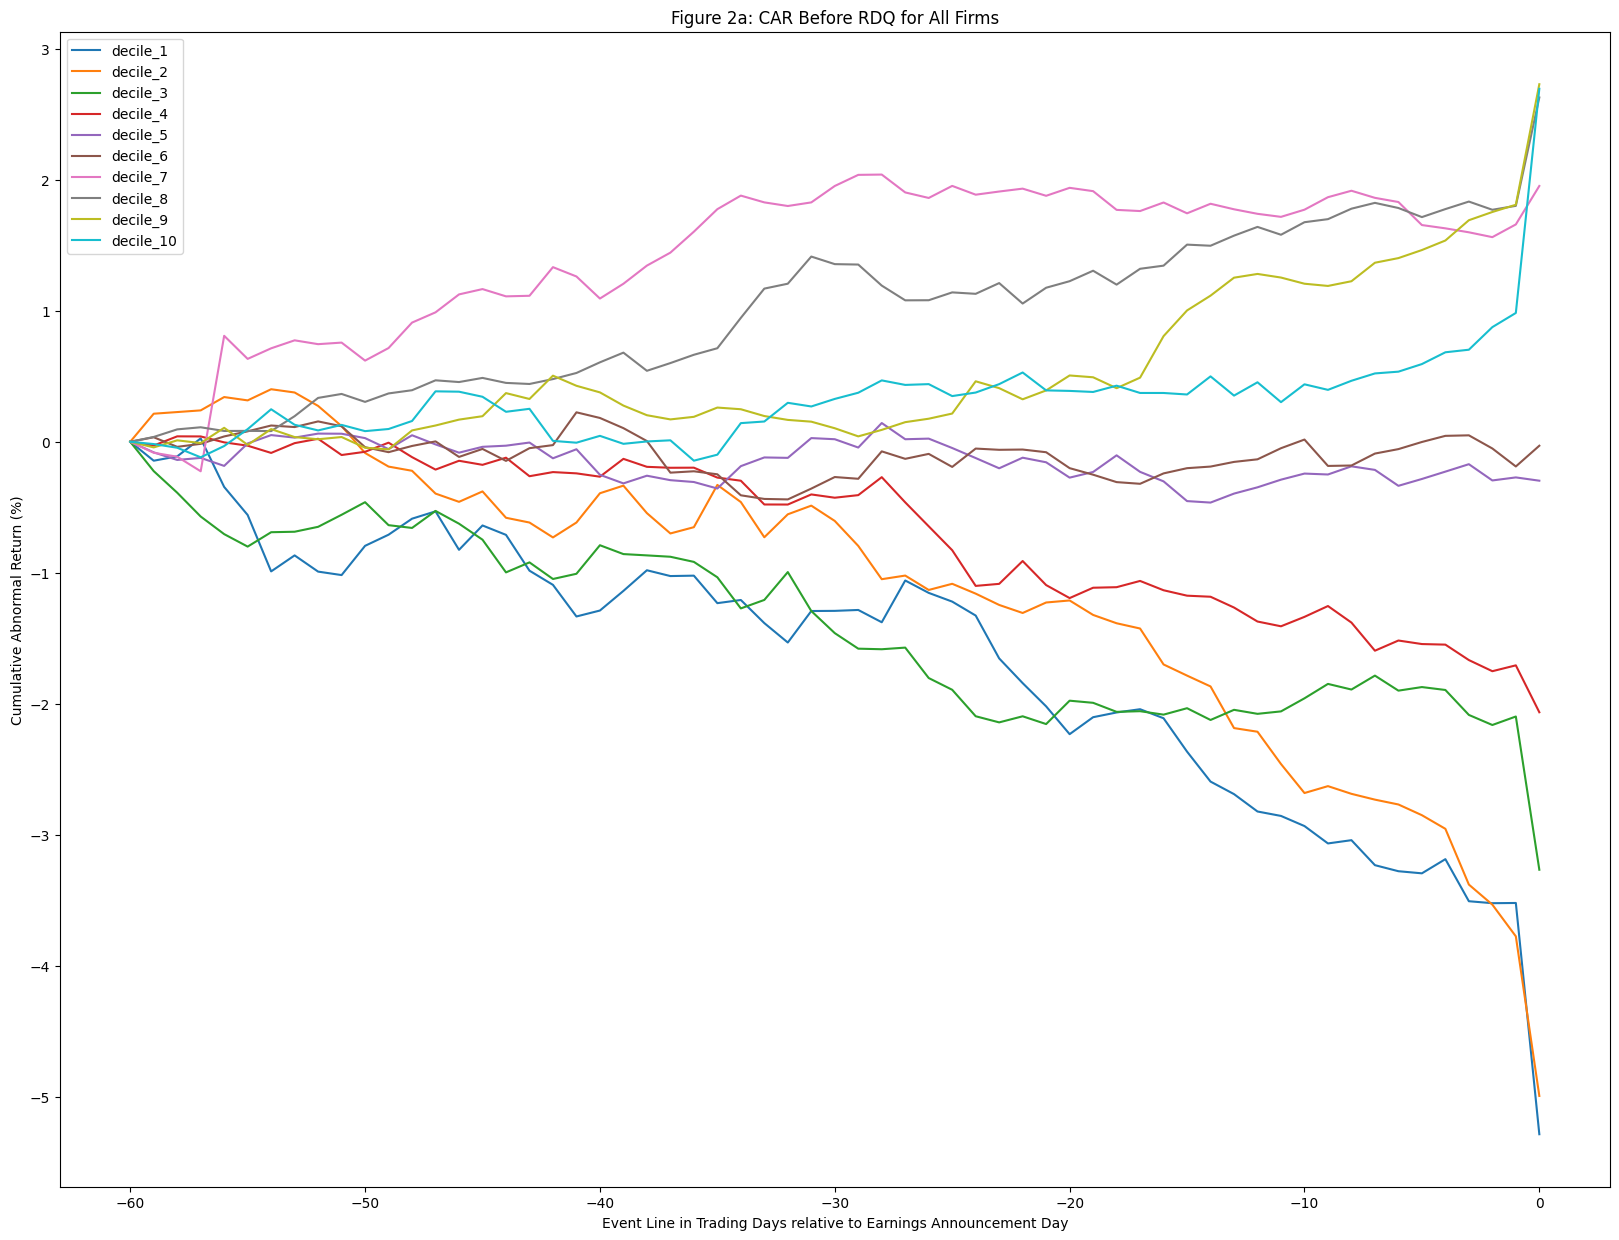

In [ ]:
## BIG FIRMS: Generate dataframe with average CAR for each day before RDQ


#New DF to store data
avgCARBigBefore = pd.DataFrame()
for i in range(1, 11):
 avgCARBigBefore['decile_' + str(i)] = 100 * pd.DataFrame(carBigByDaysBefore[i]).mean(axis = 1) # *100 for avg % CAR


#Add column to store days relative to RDQ
avgCARBigBefore = avgCARBigBefore.reset_index()
avgCARBigBefore = avgCARBigBefore.rename(columns = {'index' : 'days_relative_to_rdq'})


#Make days relative to RDQ in range [-60, 0] since data is before RDQ
avgCARBigBefore['days_relative_to_rdq'] = pd.to_numeric(avgCARBigBefore['days_relative_to_rdq'], errors = 'coerce')
avgCARBigBefore['days_relative_to_rdq'] -= 60


print(avgCARBigBefore)
print(avgCARBigBefore.columns)

##BIG FIRMS: Generate and Save Figure 2 Before RDQ

#plot graph in python
bigFirmsBeforeRDQ = avgCARBigBefore.plot(x = 'days_relative_to_rdq', y = ['decile_1', 'decile_2', 'decile_3', 'decile_4', 'decile_5', 'decile_6', 'decile_7', 'decile_8', 'decile_9', 'decile_10'], kind = "line", figsize=[20,15], title = "Figure 2a: CAR Before RDQ for All Firms")
bigFirmsBeforeRDQ.set_xlabel("Event Line in Trading Days relative to Earnings Announcement Day")
bigFirmsBeforeRDQ.set_ylabel("Cumulative Abnormal Return (%)")


#Save graph in google drive folder
fig = bigFirmsBeforeRDQ.get_figure()
fig.savefig(filePath + "/bigFirmsBeforeRDQ.png")



    days_relative_to_rdq  decile_1  decile_2  decile_3  decile_4  decile_5  \
0                      0  0.000000  0.000000  0.000000  0.000000  0.000000   
1                      1 -2.183261 -1.430634 -1.058123  0.048887  0.060333   
2                      2 -2.200740 -1.445782 -1.176919  0.027433  0.026823   
3                      3 -2.058723 -1.447307 -1.347030  0.062261 -0.005762   
4                      4 -2.029053 -1.440709 -1.454460  0.066210 -0.122970   
..                   ...       ...       ...       ...       ...       ...   
56                    56 -2.242126 -1.418102 -0.388293  0.234788  0.788499   
57                    57 -2.477896 -1.307799 -0.391807  0.380279  0.895517   
58                    58 -2.015005 -1.327772 -0.492062  0.504289  0.941042   
59                    59 -2.137091 -1.150389 -0.461763  0.421818  0.951362   
60                    60 -1.994887 -1.054348 -0.561888  0.340590  0.945902   

    decile_6  decile_7  decile_8  decile_9  decile_10  
0   0.0

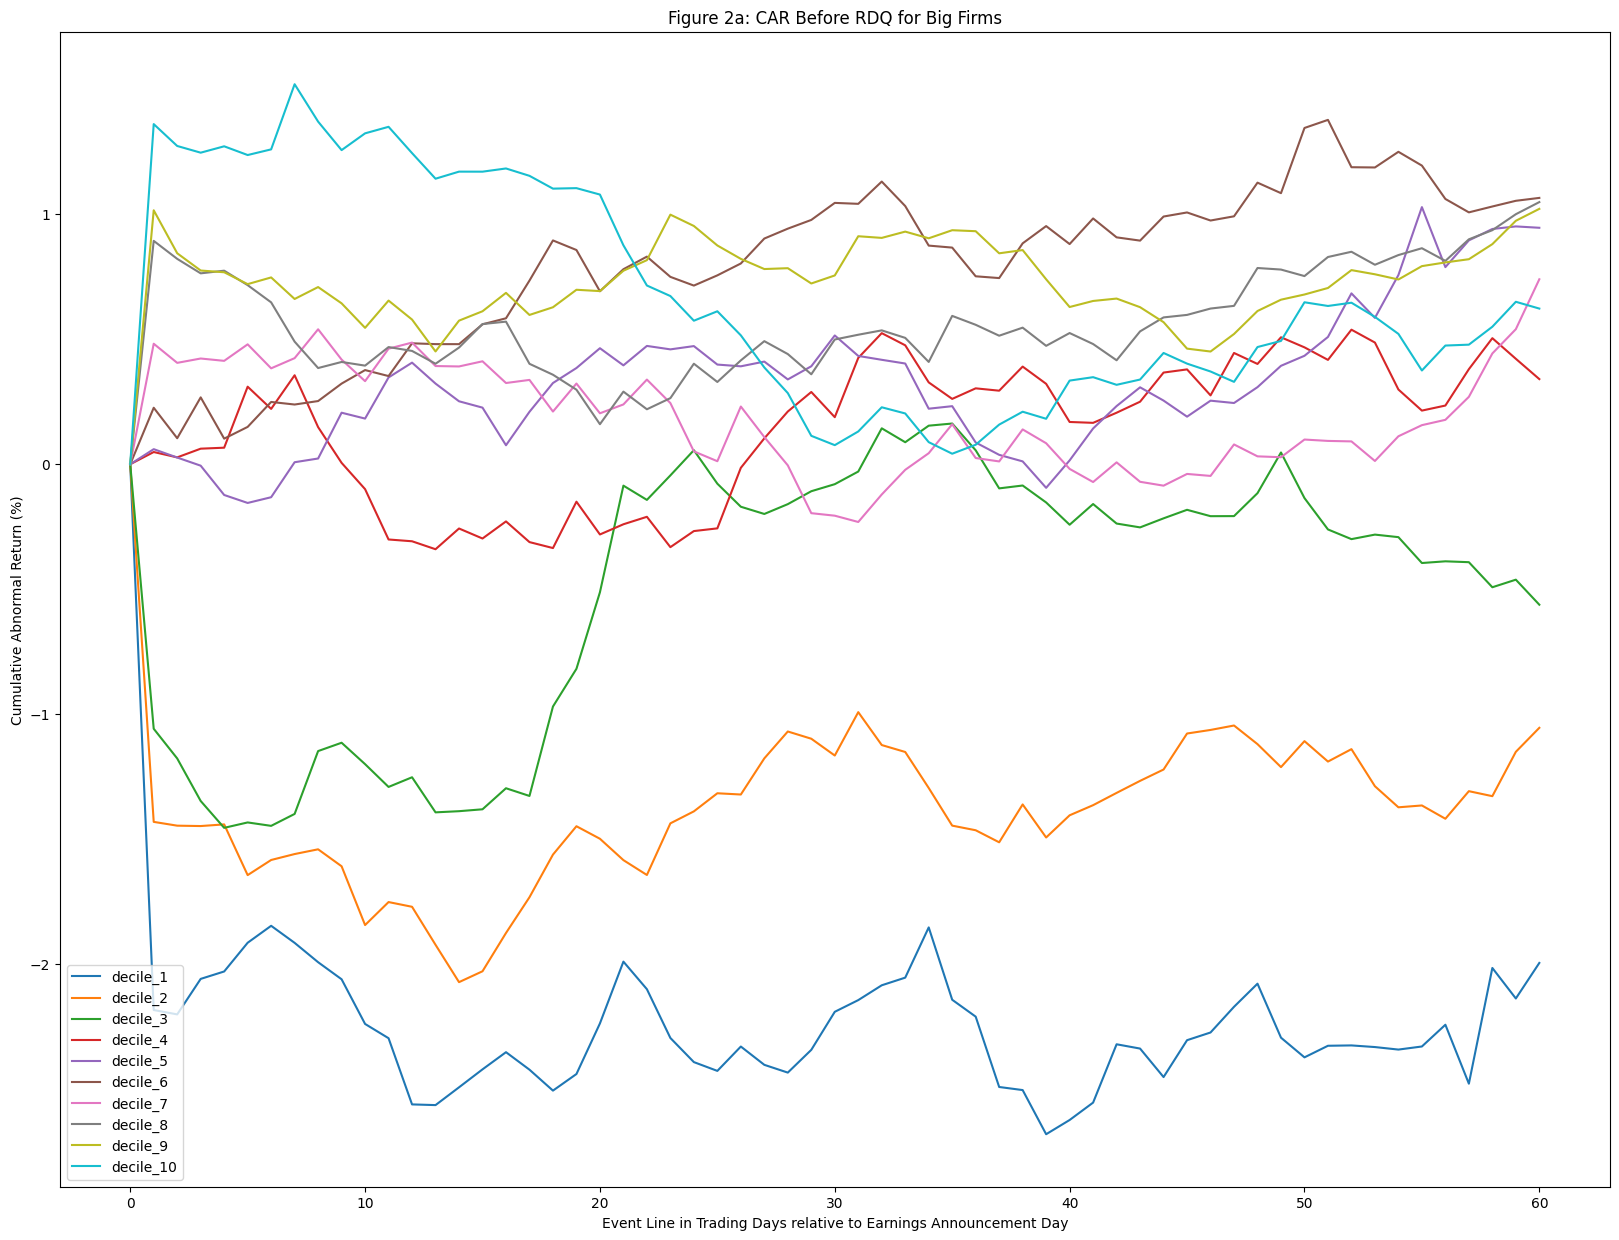

In [ ]:
## BIG FIRMS: Generate dataframe with average CAR for each day AFTER RDQ


#New DF to store data
avgCARBigAfter = pd.DataFrame()
for i in range(1, 11):
 avgCARBigAfter['decile_' + str(i)] = 100 * pd.DataFrame(carAllByDaysAfter[i]).mean(axis = 1) # *100 for avg % CAR


#Add column to store days relative to RDQ
avgCARBigAfter = avgCARBigAfter.reset_index()
avgCARBigAfter = avgCARBigAfter.rename(columns = {'index' : 'days_relative_to_rdq'})


#Make days relative to RDQ in range [-60, 0] since data is before RDQ
avgCARBigAfter['days_relative_to_rdq'] = pd.to_numeric(avgCARBigAfter['days_relative_to_rdq'], errors = 'coerce')


print(avgCARBigAfter)
print(avgCARBigAfter.columns)

##BIG FIRMS: Generate and Save Figure 2 AFTER RDQ

#plot graph in python
bigFirmsAfterRDQ = avgCARBigAfter.plot(x = 'days_relative_to_rdq', y = ['decile_1', 'decile_2', 'decile_3', 'decile_4', 'decile_5', 'decile_6', 'decile_7', 'decile_8', 'decile_9', 'decile_10'], kind = "line", figsize=[20,15], title = "Figure 2a: CAR Before RDQ for Big Firms")
bigFirmsAfterRDQ.set_xlabel("Event Line in Trading Days relative to Earnings Announcement Day")
bigFirmsAfterRDQ.set_ylabel("Cumulative Abnormal Return (%)")


#Save graph in google drive folder
fig = bigFirmsAfterRDQ.get_figure()
fig.savefig(filePath + "/bigFirmsAfterRDQ.png")





In [ ]:
## SMALL FIRMS: Calculate Cumulative abnormal returns for every RDQ




#Store mainDF for future use
mainDF = originalMain


#Only keep small firms


mainDF = mainDF[mainDF['size_decile'] <= 4]
mainDF = mainDF.reset_index()
mainDF.drop('index', inplace = True, axis = 1)


#Generate new dataframe with tic, sue decile, and size decile on RDQ
TicOfRDQSmall = mainDF.dropna()
TicOfRDQSmall = TicOfRDQSmall.filter(['tic', 'sue_decile', 'size_decile'])




#Generate new groupby variable of abnormal return with tic and original_index as indices
abnRetSmall = mainDF.reset_index()
abnRetSmall.columns = ['original_index', 'tic', 'date', 'datadate', 'year', 'qtr', 'ret', 'rdq', 'size_decile', 'avg_ret', 'abn_ret', 'sue', 'sue_decile']
abnRetSmall = abnRetSmall.groupby(['tic', 'original_index'], as_index = False)['abn_ret'].first()
abnRetSmall['new_index'] = abnRetSmall['tic'].apply(str) + "/" + abnRetSmall['original_index'].apply(str)
abnRetSmall = abnRetSmall.set_index('new_index')




#Create new array to store CAR around RDQ
carArrayBeforeSmall = []
carArrayAfterSmall = []
for i in range(11):
  carArrayBeforeSmall.append([])
  carArrayAfterSmall.append([])




#Caculate CAR and store them in corresponding SUE deciles
n = 60
for rdqDate in TicOfRDQSmall.index:
  #Generate indices for abnormal return dataframe
  nDaysBeforeIndex = str(TicOfRDQSmall['tic'][rdqDate]) + "/" + str(rdqDate - n)
  rdqDateIndex = str(TicOfRDQSmall['tic'][rdqDate]) + "/" + str(rdqDate)
  nDaysAfterIndex = str(TicOfRDQSmall['tic'][rdqDate]) + "/" + str(rdqDate + n)
  if (nDaysBeforeIndex in abnRetSmall.index) and (nDaysAfterIndex in abnRetSmall.index): #check if n days before and after RDQ abnormal return data exist
    #Add n days before CAR
    beforeDF = pd.DataFrame(abnRetSmall.loc[nDaysBeforeIndex : rdqDateIndex]).reset_index()
    beforeDF['car'] = beforeDF['abn_ret'].cumsum() - beforeDF['abn_ret'][0]
    carArrayBeforeSmall[TicOfRDQSmall['sue_decile'][rdqDate].astype(int)].append(beforeDF['car'])
    #Add n days after CAR
    afterDF = pd.DataFrame(abnRetSmall.loc[rdqDateIndex : nDaysAfterIndex]).reset_index()
    afterDF['car'] = afterDF['abn_ret'].cumsum() - afterDF['abn_ret'][0]
    carArrayAfterSmall[TicOfRDQSmall['sue_decile'][rdqDate].astype(int)].append(afterDF['car'])




## SMALL FIRMS: Generate New CAR Arrays for each decile and each day ##




#Create new array to store CAR data on each day before RDQ
carSmallByDaysBefore = []
#Set up empty array
for i in range(11):
  carSmallByDaysBefore.append([])
for j in range(61):
  carSmallByDaysBefore[i].append([])


#Add CAR data
for i in range(len(carArrayBeforeSmall)):
  for j in range(len(carArrayBeforeSmall[i])):
    for k in range(len(carSmallByDaysBefore[i])):
      carSmallByDaysBefore[i][k].append(carArrayBeforeSmall[i][j][k])


#Create new array to store CAR data on each day after RDQ
carSmallByDaysAfter = []
for i in range(11):
  carSmallByDaysAfter.append([])
for j in range(61):
  carSmallByDaysAfter[i].append([])


#Add CAR data
for i in range(len(carArrayAfterSmall)):
  for j in range(len(carArrayAfterSmall[i])):
    for k in range(len(carSmallByDaysAfter[i])):
      carSmallByDaysAfter[i][k].append(carArrayAfterSmall[i][j][k])


    days_relative_to_rdq  decile_1  decile_2  decile_3  decile_4  decile_5  \
0                    -60       NaN       NaN       NaN       NaN       NaN   
1                    -59       NaN       NaN       NaN       NaN       NaN   
2                    -58       NaN       NaN       NaN       NaN       NaN   
3                    -57       NaN       NaN       NaN       NaN       NaN   
4                    -56       NaN       NaN       NaN       NaN       NaN   
..                   ...       ...       ...       ...       ...       ...   
56                    -4       NaN       NaN       NaN       NaN       NaN   
57                    -3       NaN       NaN       NaN       NaN       NaN   
58                    -2       NaN       NaN       NaN       NaN       NaN   
59                    -1       NaN       NaN       NaN       NaN       NaN   
60                     0       NaN       NaN       NaN       NaN       NaN   

    decile_6  decile_7  decile_8  decile_9  decile_10  
0      

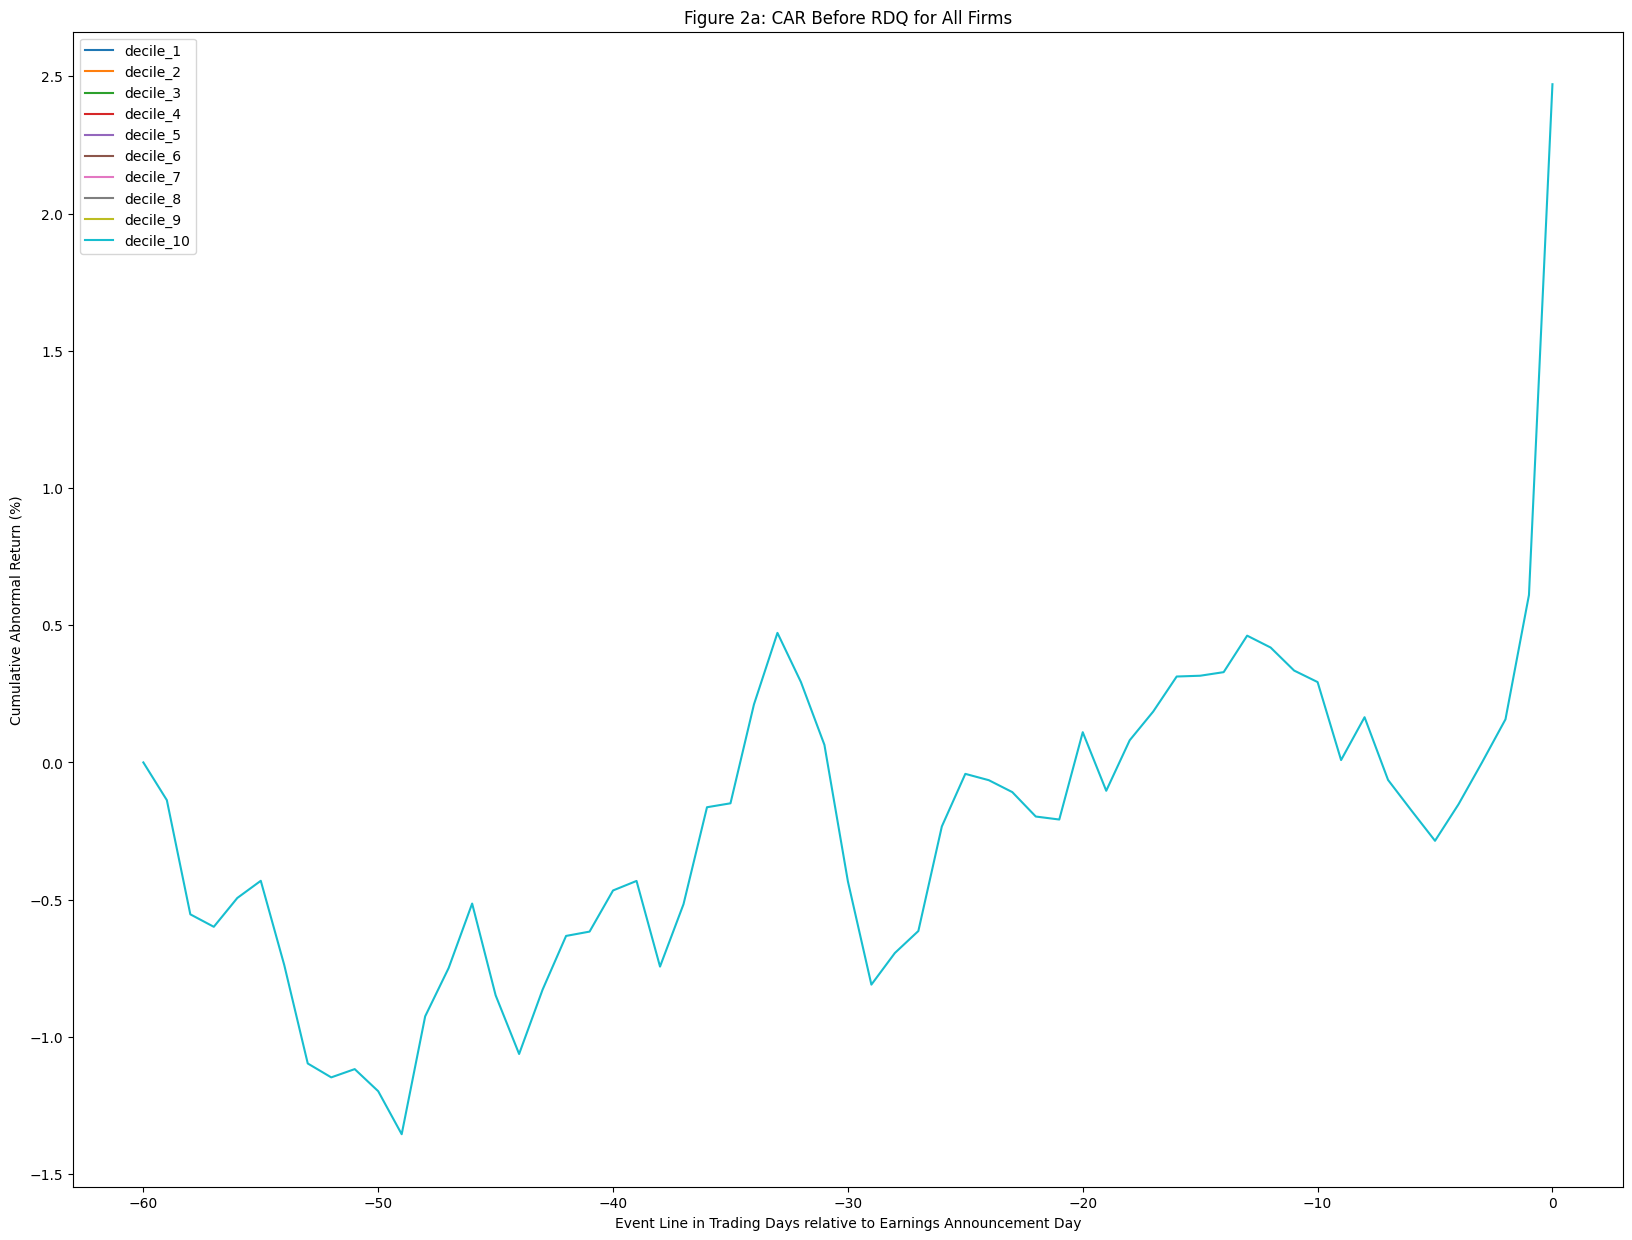

In [ ]:
## SMALL FIRMS: Generate dataframe with average CAR for each day before RDQ


#New DF to store data
avgCARSmallBefore = pd.DataFrame()
for i in range(1, 11):
  avgCARSmallBefore['decile_' + str(i)] = 100 * pd.DataFrame(carSmallByDaysBefore[i]).mean(axis = 1) # *100 for avg % CAR


#Add column to store days relative to RDQ
avgCARSmallBefore = avgCARSmallBefore.reset_index()
avgCARSmallBefore = avgCARSmallBefore.rename(columns = {'index' : 'days_relative_to_rdq'})


#Make days relative to RDQ in range [-60, 0] since data is before RDQ
avgCARSmallBefore['days_relative_to_rdq'] = pd.to_numeric(avgCARSmallBefore['days_relative_to_rdq'], errors = 'coerce')
avgCARSmallBefore['days_relative_to_rdq'] -= 60 ## ????? idk what


print(avgCARSmallBefore)
print(avgCARSmallBefore.columns)


##SMALL FIRMS: Generate and Save Figure 2 Before RDQ

#plot graph in python
smallFirmsBeforeRDQ = avgCARSmallBefore.plot(x = 'days_relative_to_rdq', y = ['decile_1', 'decile_2', 'decile_3', 'decile_4', 'decile_5', 'decile_6', 'decile_7', 'decile_8', 'decile_9', 'decile_10'], kind = "line", figsize=[20,15], title = "Figure 2a: CAR Before RDQ for All Firms")
smallFirmsBeforeRDQ.set_xlabel("Event Line in Trading Days relative to Earnings Announcement Day")
smallFirmsBeforeRDQ.set_ylabel("Cumulative Abnormal Return (%)")


#Save graph in google drive folder
fig = smallFirmsBeforeRDQ.get_figure()
fig.savefig(filePath + "/smallFirmsBeforeRDQ.png")


    days_relative_to_rdq  decile_1  decile_2  decile_3  decile_4  decile_5  \
0                      0  0.000000  0.000000  0.000000  0.000000  0.000000   
1                      1 -2.183261 -1.430634 -1.058123  0.048887  0.060333   
2                      2 -2.200740 -1.445782 -1.176919  0.027433  0.026823   
3                      3 -2.058723 -1.447307 -1.347030  0.062261 -0.005762   
4                      4 -2.029053 -1.440709 -1.454460  0.066210 -0.122970   
..                   ...       ...       ...       ...       ...       ...   
56                    56 -2.242126 -1.418102 -0.388293  0.234788  0.788499   
57                    57 -2.477896 -1.307799 -0.391807  0.380279  0.895517   
58                    58 -2.015005 -1.327772 -0.492062  0.504289  0.941042   
59                    59 -2.137091 -1.150389 -0.461763  0.421818  0.951362   
60                    60 -1.994887 -1.054348 -0.561888  0.340590  0.945902   

    decile_6  decile_7  decile_8  decile_9  decile_10  
0   0.0

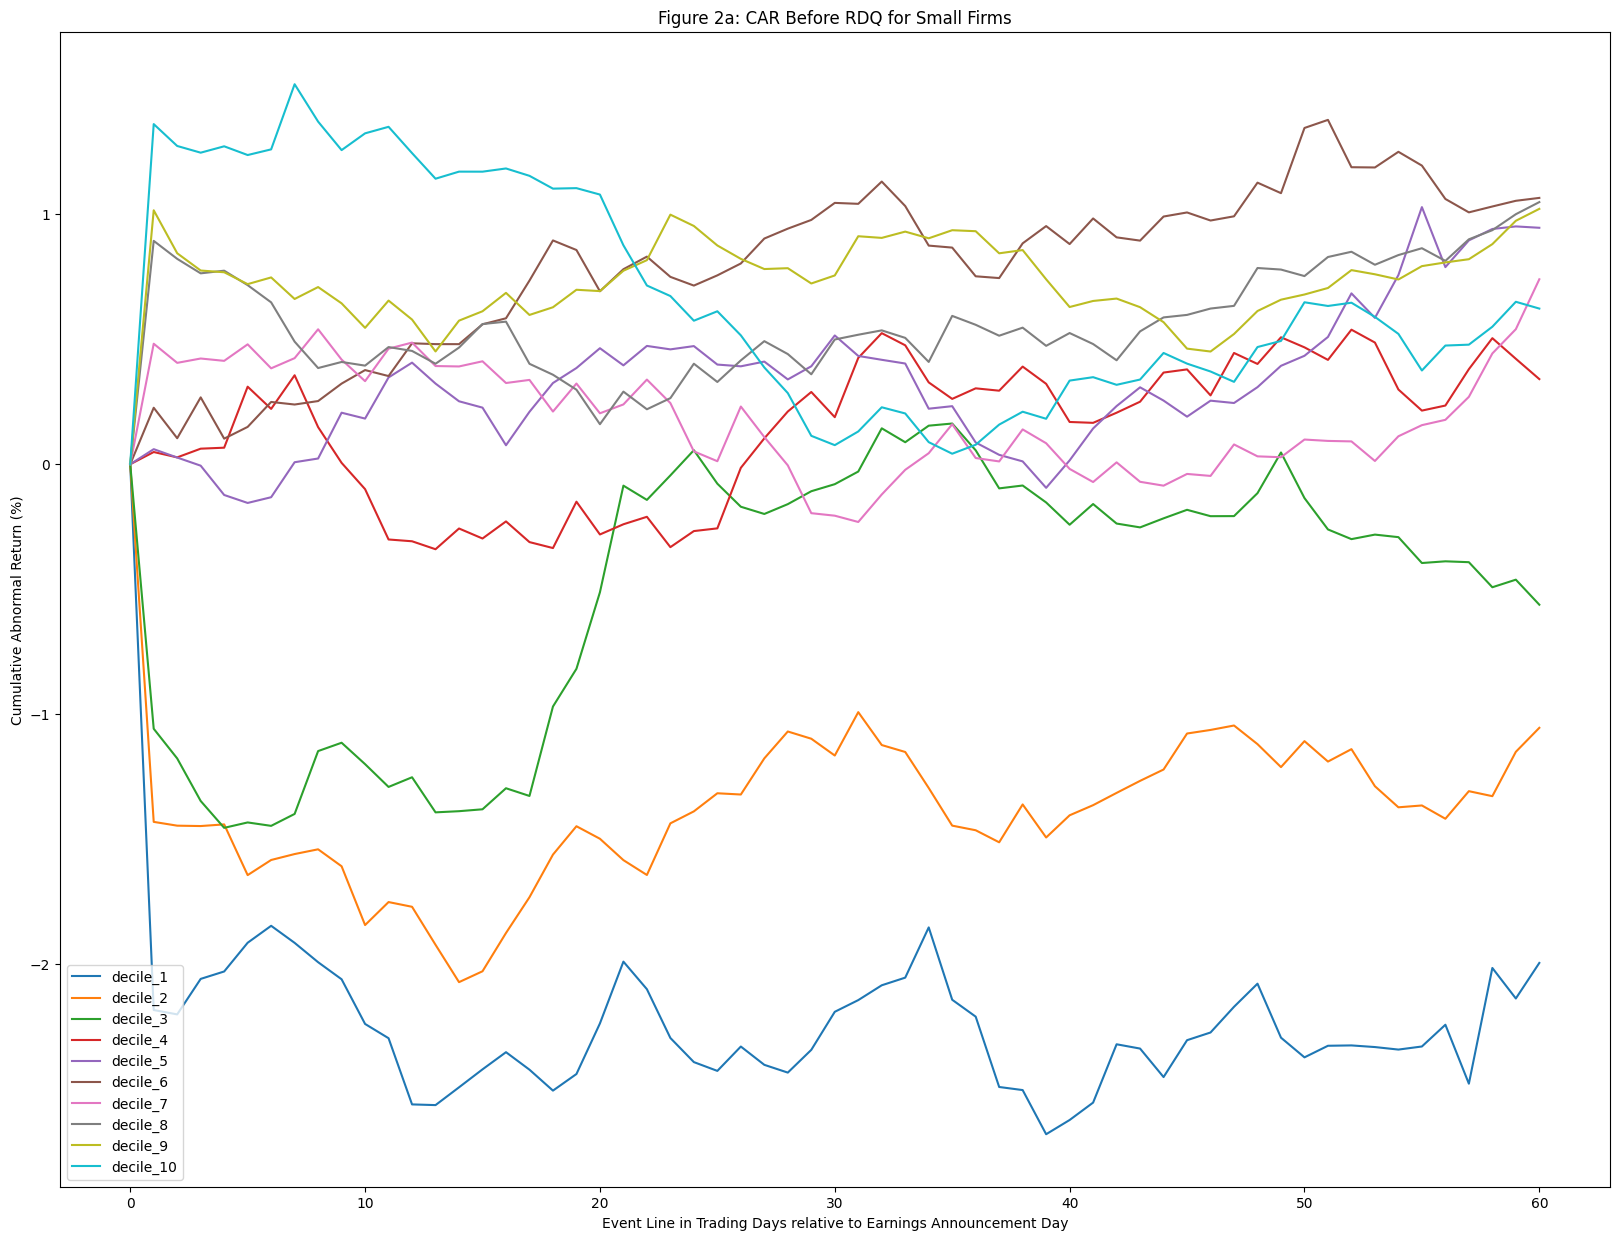

In [ ]:
## SMALL FIRMS: Generate dataframe with average CAR for each day AFTER RDQ


#New DF to store data
avgCARSmallAfter = pd.DataFrame()
for i in range(1, 11):
  avgCARSmallAfter['decile_' + str(i)] = 100 * pd.DataFrame(carAllByDaysAfter[i]).mean(axis = 1) # *100 for avg % CAR


#Add column to store days relative to RDQ
avgCARSmallAfter = avgCARSmallAfter.reset_index()
avgCARSmallAfter = avgCARSmallAfter.rename(columns = {'index' : 'days_relative_to_rdq'})


#Make days relative to RDQ in range [-60, 0] since data is before RDQ
avgCARSmallAfter['days_relative_to_rdq'] = pd.to_numeric(avgCARSmallAfter['days_relative_to_rdq'], errors = 'coerce')

print(avgCARSmallAfter)
print(avgCARSmallAfter.columns)


## SMALL FIRMS: Generate and Save Figure 2 AFTER RDQ


#plot graph in python
smallFirmsAfterRDQ = avgCARSmallAfter.plot(x = 'days_relative_to_rdq', y = ['decile_1', 'decile_2', 'decile_3', 'decile_4', 'decile_5', 'decile_6', 'decile_7', 'decile_8', 'decile_9', 'decile_10'], kind = "line", figsize=[20,15], title = "Figure 2a: CAR Before RDQ for Small Firms")
smallFirmsAfterRDQ.set_xlabel("Event Line in Trading Days relative to Earnings Announcement Day")
smallFirmsAfterRDQ.set_ylabel("Cumulative Abnormal Return (%)")


#Save graph in google drive folder
fig = smallFirmsAfterRDQ.get_figure()
fig.savefig(filePath + "/smallFirmsAfterRDQ.png")


In [ ]:
## MED FIRMS: Calculate Cumulative abnormal returns for every RDQ


#Store mainDF for future use
mainDF = originalMain


#Only keep med firms


mainDF = mainDF[(mainDF['size_decile'] >= 5) & (mainDF['size_decile'] <= 7)]
mainDF = mainDF.reset_index()
mainDF.drop('index', inplace = True, axis = 1)


#Generate new dataframe with tic, sue decile, and size decile on RDQ
TicOfRDQMed = mainDF.dropna()
TicOfRDQMed = TicOfRDQMed.filter(['tic', 'sue_decile', 'size_decile'])

#Generate new groupby variable of abnormal return with tic and original_index as indices
abnRetMed = mainDF.reset_index()
abnRetMed.columns = ['original_index', 'tic', 'date', 'datadate', 'year', 'qtr', 'ret', 'rdq', 'size_decile', 'avg_ret', 'abn_ret', 'sue', 'sue_decile']
abnRetMed = abnRetMed.groupby(['tic', 'original_index'], as_index = False)['abn_ret'].first()
abnRetMed['new_index'] = abnRetMed['tic'].apply(str) + "/" + abnRetMed['original_index'].apply(str)
abnRetMed = abnRetMed.set_index('new_index')



#Create new array to store CAR around RDQ
carArrayBeforeMed = []
carArrayAfterMed = []
for i in range(11):
 carArrayBeforeMed.append([])
 carArrayAfterMed.append([])


#Caculate CAR and store them in corresponding SUE deciles
n = 60
for rdqDate in TicOfRDQMed.index:
 #Generate indices for abnormal return dataframe
 nDaysBeforeIndex = str(TicOfRDQMed['tic'][rdqDate]) + "/" + str(rdqDate - n)
 rdqDateIndex = str(TicOfRDQMed['tic'][rdqDate]) + "/" + str(rdqDate)
 nDaysAfterIndex = str(TicOfRDQMed['tic'][rdqDate]) + "/" + str(rdqDate + n)
 if (nDaysBeforeIndex in abnRetMed.index) and (nDaysAfterIndex in abnRetMed.index): #check if n days before and after RDQ abnormal return data exist
   #Add n days before CAR
   beforeDF = pd.DataFrame(abnRetMed.loc[nDaysBeforeIndex : rdqDateIndex]).reset_index()
   beforeDF['car'] = beforeDF['abn_ret'].cumsum() - beforeDF['abn_ret'][0]
   carArrayBeforeMed[TicOfRDQMed['sue_decile'][rdqDate].astype(int)].append(beforeDF['car'])
   #Add n days after CAR
   afterDF = pd.DataFrame(abnRetMed.loc[rdqDateIndex : nDaysAfterIndex]).reset_index()
   afterDF['car'] = afterDF['abn_ret'].cumsum() - afterDF['abn_ret'][0]
   carArrayAfterMed[TicOfRDQMed['sue_decile'][rdqDate].astype(int)].append(afterDF['car'])

## MED FIRMS: Generate New CAR Arrays for each decile and each day ##

#Create new array to store CAR data on each day before RDQ
carMedByDaysBefore = []
#Set up empty array
for i in range(11):
 carMedByDaysBefore.append([])
for j in range(61):
 carMedByDaysBefore[i].append([])


#Add CAR data
for i in range(len(carArrayBeforeMed)):
 for j in range(len(carArrayBeforeMed[i])):
   for k in range(len(carMedByDaysBefore[i])):
     carMedByDaysBefore[i][k].append(carArrayBeforeMed[i][j][k])


#Create new array to store CAR data on each day after RDQ
carMedByDaysAfter = []
for i in range(11):
 carMedByDaysAfter.append([])
for j in range(61):
 carMedByDaysAfter[i].append([])


#Add CAR data
for i in range(len(carArrayAfterMed)):
 for j in range(len(carArrayAfterMed[i])):
   for k in range(len(carMedByDaysAfter[i])):
     carMedByDaysAfter[i][k].append(carArrayAfterMed[i][j][k])


In [ ]:
## MED FIRMS: Generate dataframe with average CAR for each day before RDQ

#New DF to store data
avgCARMedBefore = pd.DataFrame()
for i in range(1, 11):
 avgCARMedBefore['decile_' + str(i)] = 100 * pd.DataFrame(carMedByDaysBefore[i]).mean(axis = 1) # *100 for avg % CAR


#Add column to store days relative to RDQ
avgCARMedBefore = avgCARMedBefore.reset_index()
avgCARMedBefore = avgCARMedBefore.rename(columns = {'index' : 'days_relative_to_rdq'})


#Make days relative to RDQ in range [-60, 0] since data is before RDQ
avgCARMedBefore['days_relative_to_rdq'] = pd.to_numeric(avgCARMedBefore['days_relative_to_rdq'], errors = 'coerce')
avgCARMedBefore['days_relative_to_rdq'] -= 60 ## ????? idk what


print(avgCARMedBefore)
print(avgCARMedBefore.columns)

    days_relative_to_rdq  decile_1  decile_2  decile_3  decile_4  decile_5  \
0                    -60       NaN       NaN       NaN       NaN       NaN   
1                    -59       NaN       NaN       NaN       NaN       NaN   
2                    -58       NaN       NaN       NaN       NaN       NaN   
3                    -57       NaN       NaN       NaN       NaN       NaN   
4                    -56       NaN       NaN       NaN       NaN       NaN   
..                   ...       ...       ...       ...       ...       ...   
56                    -4       NaN       NaN       NaN       NaN       NaN   
57                    -3       NaN       NaN       NaN       NaN       NaN   
58                    -2       NaN       NaN       NaN       NaN       NaN   
59                    -1       NaN       NaN       NaN       NaN       NaN   
60                     0       NaN       NaN       NaN       NaN       NaN   

    decile_6  decile_7  decile_8  decile_9  decile_10  
0      

In [ ]:
## MED FIRMS: Generate dataframe with average CAR for each day AFTER RDQ

#New DF to store data
avgCARMedAfter = pd.DataFrame()
for i in range(1, 11):
 avgCARMedAfter['decile_' + str(i)] = 100 * pd.DataFrame(carAllByDaysAfter[i]).mean(axis = 1) # *100 for avg % CAR

#Add column to store days relative to RDQ
avgCARMedAfter = avgCARMedAfter.reset_index()
avgCARMedAfter = avgCARMedAfter.rename(columns = {'index' : 'days_relative_to_rdq'})

#Make days relative to RDQ in range [-60, 0] since data is before RDQ
avgCARMedAfter['days_relative_to_rdq'] = pd.to_numeric(avgCARMedAfter['days_relative_to_rdq'], errors = 'coerce')

print(avgCARMedAfter)
print(avgCARMedAfter.columns)

    days_relative_to_rdq  decile_1  decile_2  decile_3  decile_4  decile_5  \
0                      0  0.000000  0.000000  0.000000  0.000000  0.000000   
1                      1 -2.183261 -1.430634 -1.058123  0.048887  0.060333   
2                      2 -2.200740 -1.445782 -1.176919  0.027433  0.026823   
3                      3 -2.058723 -1.447307 -1.347030  0.062261 -0.005762   
4                      4 -2.029053 -1.440709 -1.454460  0.066210 -0.122970   
..                   ...       ...       ...       ...       ...       ...   
56                    56 -2.242126 -1.418102 -0.388293  0.234788  0.788499   
57                    57 -2.477896 -1.307799 -0.391807  0.380279  0.895517   
58                    58 -2.015005 -1.327772 -0.492062  0.504289  0.941042   
59                    59 -2.137091 -1.150389 -0.461763  0.421818  0.951362   
60                    60 -1.994887 -1.054348 -0.561888  0.340590  0.945902   

    decile_6  decile_7  decile_8  decile_9  decile_10  
0   0.0

In [ ]:
# Generate CAR data for every 60d period until day 480

periodLength = 15
periodStartsToAnalyse = [-59, -44, -29, -14, 1, 16, 31, 46, 61]

#Big firms
#Fill new dataframe with empty arrays to get CAR
TicOfRDQBigHiLo = TicOfRDQBig[(TicOfRDQBig['sue_decile'] == 1) | (TicOfRDQBig['sue_decile'] == 10)] #Filter only for extremes
carDaysAfterRDQBig = pd.DataFrame(index = periodStartsToAnalyse, columns = [1,10]) #Day to analyse as index, only extremity columns
for i in carDaysAfterRDQBig.index:
  for j in carDaysAfterRDQBig.columns:
    carDaysAfterRDQBig[j][i] = []

#Fill dataframe with arrays of CAR on the last day of the period
for m in carDaysAfterRDQBig.index:
  for rdqDate in TicOfRDQBigHiLo.index:
    #Generate indices for abnormal return DF
    mDaysAfterRDQStartIndex = str(TicOfRDQBigHiLo['tic'][rdqDate]) + "/" + str(rdqDate + m)
    mDaysAfterRDQEndIndex = str(TicOfRDQBigHiLo['tic'][rdqDate]) + "/" + str(rdqDate + m + periodLength - 1)
    if (mDaysAfterRDQStartIndex in abnRetBig.index) and (mDaysAfterRDQEndIndex in abnRetBig.index):
      periodDF = pd.DataFrame(abnRetBig.loc[mDaysAfterRDQStartIndex : mDaysAfterRDQEndIndex]).reset_index()
      periodDF['car'] = periodDF['abn_ret'].cumsum()
      carDaysAfterRDQBig[TicOfRDQBigHiLo['sue_decile'][rdqDate]][m].append(periodDF['car'][periodLength - 1])

#Take averages of each array to get car on final day
for i in carDaysAfterRDQBig.index:
  for j in carDaysAfterRDQBig.columns:
    carDaysAfterRDQBig[j][i] = np.average(carDaysAfterRDQBig[j][i]) * 100 #multiply by 100 for percent value

print(carDaysAfterRDQBig)
print(carDaysAfterRDQBig.columns)

           1         10
-59 -0.895484  0.296756
-44  -0.91164 -0.155153
-29 -0.800539 -0.154541
-14 -2.442754  2.319221
 1  -2.522747  1.263034
 16 -0.435776  -0.66696
 31  0.256105 -0.286136
 46  0.137704  0.409561
 61  0.981669 -0.761995
Int64Index([1, 10], dtype='int64')


In [ ]:
# Generate CAR data for every 60d period until day 480

periodLength = 15
periodStartsToAnalyse = [-59, -44, -29, -14, 1, 16, 31, 46, 61]

#Med firms
#Fill new dataframe with empty arrays to get CAR
TicOfRDQMedHiLo = TicOfRDQMed[(TicOfRDQMed['sue_decile'] == 1) | (TicOfRDQMed['sue_decile'] == 10)] #Filter only for extremes
carDaysAfterRDQMed = pd.DataFrame(index = periodStartsToAnalyse, columns = [1,10]) #Day to analyse as index, only extremity columns
for i in carDaysAfterRDQMed.index:
 for j in carDaysAfterRDQMed.columns:
   carDaysAfterRDQMed[j][i] = []

#Fill dataframe with arrays of CAR on the last day of the period
for m in carDaysAfterRDQMed.index:
 for rdqDate in TicOfRDQMedHiLo.index:
   #Generate indices for abnormal return DF
   mDaysAfterRDQStartIndex = str(TicOfRDQMedHiLo['tic'][rdqDate]) + "/" + str(rdqDate + m)
   mDaysAfterRDQEndIndex = str(TicOfRDQMedHiLo['tic'][rdqDate]) + "/" + str(rdqDate + m + periodLength - 1)
   if (mDaysAfterRDQStartIndex in abnRetMed.index) and (mDaysAfterRDQEndIndex in abnRetMed.index):
     periodDF = pd.DataFrame(abnRetMed.loc[mDaysAfterRDQStartIndex : mDaysAfterRDQEndIndex]).reset_index()
     periodDF['car'] = periodDF['abn_ret'].cumsum()
     carDaysAfterRDQMed[TicOfRDQMedHiLo['sue_decile'][rdqDate]][m].append(periodDF['car'][periodLength - 1])

#Take averages of each array to get car on final day
for i in carDaysAfterRDQMed.index:
 for j in carDaysAfterRDQMed.columns:
   carDaysAfterRDQMed[j][i] = np.average(carDaysAfterRDQMed[j][i]) * 100 #multiply by 100 for percent value

print(carDaysAfterRDQMed)
print(carDaysAfterRDQMed.columns)


           1         10
-59  0.166849  0.530018
-44  -0.36732 -0.329445
-29 -1.521046  0.940446
-14 -2.535077  2.352414
 1   -1.36544  1.353244
 16  0.533433 -0.902828
 31 -0.515376  0.522359
 46  0.232261  0.159798
 61 -0.876499  0.044191
Int64Index([1, 10], dtype='int64')


In [ ]:
# Generate CAR data for every 60d period until day 480

periodLength = 15
periodStartsToAnalyse = [-59, -44, -29, -14, 1, 16, 31, 46, 61]

#Small firms
#Fill new dataframe with empty arrays to get CAR
TicOfRDQSmallHiLo = TicOfRDQSmall[(TicOfRDQSmall['sue_decile'] == 1) | (TicOfRDQSmall['sue_decile'] == 10)] #Filter only for extremes
carDaysAfterRDQSmall = pd.DataFrame(index = periodStartsToAnalyse, columns = [1,10]) #Day to analyse as index, only extremity columns
for i in carDaysAfterRDQSmall.index:
  for j in carDaysAfterRDQSmall.columns:
   carDaysAfterRDQSmall[j][i] = []

#Fill dataframe with arrays of CAR on the last day of the period
for m in carDaysAfterRDQSmall.index:
  for rdqDate in TicOfRDQSmallHiLo.index:
    #Generate indices for abnormal return DF
    mDaysAfterRDQStartIndex = str(TicOfRDQSmallHiLo['tic'][rdqDate]) + "/" + str(rdqDate + m)
    mDaysAfterRDQEndIndex = str(TicOfRDQSmallHiLo['tic'][rdqDate]) + "/" + str(rdqDate + m + periodLength - 1)
    if (mDaysAfterRDQStartIndex in abnRetSmall.index) and (mDaysAfterRDQEndIndex in abnRetSmall.index):
      periodDF = pd.DataFrame(abnRetSmall.loc[mDaysAfterRDQStartIndex : mDaysAfterRDQEndIndex]).reset_index()
      periodDF['car'] = periodDF['abn_ret'].cumsum()
      carDaysAfterRDQSmall[TicOfRDQSmallHiLo['sue_decile'][rdqDate]][m].append(periodDF['car'][periodLength - 1])

#Take averages of each array to get car on final day
for i in carDaysAfterRDQSmall.index:
  for j in carDaysAfterRDQSmall.columns:
    carDaysAfterRDQSmall[j][i] = np.average(carDaysAfterRDQSmall[j][i]) * 100 #multiply by 100 for percent value

print(carDaysAfterRDQSmall)
print(carDaysAfterRDQSmall.columns)


           1         10
-59 -0.326684 -0.447643
-44 -0.337573  0.560625
-29 -0.643487  0.903951
-14 -1.381979  1.810127
 1  -2.911994   0.71384
 16  0.522005 -1.973199
 31 -0.150897   0.81779
 46  0.392457  0.403567
 61 -0.135122 -1.109249
Int64Index([1, 10], dtype='int64')


In [ ]:
#Print out table 1
table1A = pd.DataFrame(index = range(9))
table1A["holding_period"] = ["-59 to -45", "-44 to -30", "-29 to -15", "-14 to 0", "1 to 15", "16 to 30", "31 to 45", "46 to 60", "61 to 75"]
for i in ["s", "m", "b"]:
  for j in ["h", "l", "diff"]:
    table1A[(i + "/" + j)] = ""

#Small/high SUE firms
for i in range(0, 9):
  table1A['s/h'][i] = carDaysAfterRDQSmall[10][(i - 4) * 15 + 1]

#Small/low SUE firms
for i in range(0, 9):
  table1A['s/l'][i] = carDaysAfterRDQSmall[1][(i - 4) * 15 + 1]

#Small/diff
table1A['s/diff'] = table1A['s/h'] - table1A['s/l']

#Medium/high SUE firms
for i in range(0, 9):
  table1A['m/h'][i] = carDaysAfterRDQMed[10][(i - 4) * 15 + 1]

#Medium/low SUE firms
for i in range(0, 9):
  table1A['m/l'][i] = carDaysAfterRDQMed[1][(i - 4) * 15 + 1]

#Medium/diff
table1A['m/diff'] = table1A['m/h'] = table1A['m/l']

#Big/high SUE firms
for i in range(0, 9):
  table1A['b/h'][i] = carDaysAfterRDQBig[10][(i - 4) * 15 + 1]

#Big/low SUE firms
for i in range(0, 9):
  table1A['b/l'][i] = carDaysAfterRDQBig[1][(i - 4) * 15 + 1]

#Big/diff
table1A['b/diff'] = table1A['b/h'] - table1A['b/l']

table1B = pd.DataFrame(index = range(5))
table1B['holding_period'] = ["1 to 15", "1 to 30", "1 to 45", "1 to 60", "1 to 75"]
for i in ["s", "m", "b"]:
  table1B[i + "/diff"] = ""
  table1B[i + "/diff_as_fraction_of_75d_drift"] = ""

for i in ['s/diff', 'm/diff', 'b/diff']:
  table1B[i][0] = table1A[i][4]
  table1B[i][1] = table1B[i][0] + table1A[i][5]
  table1B[i][2] = table1B[i][1] + table1A[i][6]
  table1B[i][3] = table1B[i][2] + table1A[i][7]
  table1B[i][4] = table1B[i][3] + table1A[i][8]

table1B['s/diff_as_fraction_of_75d_drift'] = table1B['s/diff']/table1B['s/diff'][4]
table1B['m/diff_as_fraction_of_75d_drift'] = table1B['m/diff']/table1B['m/diff'][4]
table1B['b/diff_as_fraction_of_75d_drift'] = table1B['b/diff']/table1B['b/diff'][4]

print(table1A)
print(table1B)

  holding_period       s/h       s/l    s/diff       m/h       m/l    m/diff  \
0     -59 to -45 -0.447643 -0.326684 -0.120959  0.166849  0.166849  0.166849   
1     -44 to -30  0.560625 -0.337573  0.898198  -0.36732  -0.36732  -0.36732   
2     -29 to -15  0.903951 -0.643487  1.547438 -1.521046 -1.521046 -1.521046   
3       -14 to 0  1.810127 -1.381979  3.192106 -2.535077 -2.535077 -2.535077   
4        1 to 15   0.71384 -2.911994  3.625834  -1.36544  -1.36544  -1.36544   
5       16 to 30 -1.973199  0.522005 -2.495204  0.533433  0.533433  0.533433   
6       31 to 45   0.81779 -0.150897  0.968686 -0.515376 -0.515376 -0.515376   
7       46 to 60  0.403567  0.392457   0.01111  0.232261  0.232261  0.232261   
8       61 to 75 -1.109249 -0.135122 -0.974127 -0.876499 -0.876499 -0.876499   

        b/h       b/l    b/diff  
0  0.296756 -0.895484   1.19224  
1 -0.155153  -0.91164  0.756487  
2 -0.154541 -0.800539  0.645998  
3  2.319221 -2.442754  4.761975  
4  1.263034 -2.522747  3.7857

In [ ]:
#Extreme GN/BN FIRMS: Generate 30 and 60-day Cumulative Abnormal returns with different method including date of data for Table 3

mainDF = originalMain
mainDFHiLo = mainDF[(mainDF['sue_decile'] == 1) | (mainDF['sue_decile'] == 10)]

#Generate new DF with tic, SUE decile, and size decile on RDQ
TicOfRDQHiLo = mainDFHiLo.dropna()
TicOfRDQHiLo = TicOfRDQHiLo.filter(['tic', 'sue_decile', 'size_decile'])

#Generate new groupby variable of abn ret with tic and original_index as indices
abnRetHiLo = mainDFHiLo.reset_index()
abnRetHiLo.columns = ['original_index', 'tic', 'date', 'datadate', 'year', 'qtr', 'ret', 'rdq', 'size_decile', 'avg_ret', 'abn_ret', 'sue', 'sue_decile']
abnRetHiLo = abnRetHiLo.groupby(['tic', 'original_index'], as_index = False)['abn_ret'].first()
abnRetHiLo['new_index'] = abnRetHiLo['tic'].apply(str) + "/" + abnRetHiLo['original_index'].apply(str)
abnRetHiLo = abnRetHiLo.set_index('new_index')

#Create new DF to store CAR around RDQ
car30dHiLoWithDates = mainDF.filter(['tic', 'date', 'sue_decile'])
car30dHiLoWithDates['days_after_rdq'] = ""
car30dHiLoWithDates['car'] = ""

car60dHiLoWithDates = mainDF.filter(['tic', 'date', 'sue_decile'])
car60dHiLoWithDates['days_after_rdq'] = ""
car60dHiLoWithDates['car'] = ""

#Calculate CAR and store them in corresponding SUE deciles
n = 30
for rdqDate in TicOfRDQHiLo.index:
  rdqDateIndex = str(TicOfRDQHiLo['tic'][rdqDate]) + "/" + str(rdqDate)
  nDaysAfterIndex = str(TicOfRDQHiLo['tic'][rdqDate]) + "/" + str(rdqDate + n)
  if nDaysAfterIndex in abnRetHiLo.index:
    afterDF = pd.DataFrame(abnRet.loc[rdqDateIndex : nDaysAfterIndex]).reset_index()
    afterDF['car'] = afterDF['abn_ret'].cumsum() - afterDF['abn_ret'][0]
    car30dHiLoWithDates['days_after_rdq'][rdqDate: rdqDate + n + 1] = afterDF.index
    car30dHiLoWithDates['car'][rdqDate : rdqDate + n + 1] = afterDF['car']

m = 60
for rdqDate in TicOfRDQHiLo.index:
  rdqDateIndex = str(TicOfRDQHiLo['tic'][rdqDate]) + "/" + str(rdqDate)
  nDaysAfterIndex = str(TicOfRDQHiLo['tic'][rdqDate]) + "/" + str(rdqDate + m)
  if nDaysAfterIndex in abnRetHiLo.index:
    afterDF = pd.DataFrame(abnRet.loc[rdqDateIndex : nDaysAfterIndex]).reset_index()
    afterDF['car'] = afterDF['abn_ret'].cumsum() - afterDF['abn_ret'][0]
    car60dHiLoWithDates['days_after_rdq'][rdqDate: rdqDate + m + 1] = afterDF.index
    car60dHiLoWithDates['car'][rdqDate : rdqDate + m + 1] = afterDF['car']

car30dHiLoWithDates['car'] *= 100
car30dHiLoWithDates = car30dHiLoWithDates[car30dHiLoWithDates['days_after_rdq'] == 30]

car60dHiLoWithDates['car'] *= 100
car60dHiLoWithDates = car60dHiLoWithDates[car60dHiLoWithDates['days_after_rdq'] == 60]

print(car30dHiLoWithDates)
print(car60dHiLoWithDates)


Streaming output truncated to the last 5000 lines.
<ipython-input-37-ba805587e731>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car60dHiLoWithDates['days_after_rdq'][rdqDate: rdqDate + m + 1] = afterDF.index
<ipython-input-37-ba805587e731>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car60dHiLoWithDates['car'][rdqDate : rdqDate + m + 1] = afterDF['car']
<ipython-input-37-ba805587e731>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

         tic       date  sue_decile days_after_rdq        car
2993     AAN 2021-06-09        10.0             30  -0.291878
3383     AAP 2019-09-25         1.0             30  10.847086
3512     AAP 2020-03-31        10.0             30   -2.91405
3763     AAP 2021-03-30         1.0             30  16.421177
5268     ABC 2020-09-17        10.0             30  -7.865754
...      ...        ...         ...            ...        ...
1104424  ZEN 2021-03-19         1.0             30 -24.311748
1104545  ZEN 2021-09-10         1.0             30 -24.827107
1106125  ZTS 2021-06-18        10.0             30  11.016325
1106711  ZUO 2020-07-16        10.0             30 -11.063857
1106775  ZUO 2020-10-15        10.0             30 -34.280234

[2020 rows x 5 columns]
          tic       date  sue_decile days_after_rdq         car
9532      ACA 2021-05-20        10.0             60  -10.787171
17473     ADT 2021-02-03         1.0             60    3.360601
17596     ADT 2021-07-30         1.0   

In [ ]:
#Replicate Table 3

file = filePath + '/F-F_Research_Data_5_Factors_Daily.csv'
ffDF = pd.read_csv(file)

#Convert variables
ffDF['Date'] = pd.to_datetime(ffDF['Date'], format = '%Y%m%d')
ffDF['SMB'] = pd.to_numeric(ffDF['SMB'], errors = 'coerce')
ffDF['HML'] = pd.to_numeric(ffDF['HML'], errors = 'coerce')
ffDF['RMW'] = pd.to_numeric(ffDF['RMW'], errors = 'coerce')
ffDF['CMA'] = pd.to_numeric(ffDF['CMA'], errors = 'coerce')
ffDF['RF'] = pd.to_numeric(ffDF['RF'], errors = 'coerce')

#Add MKT column
ffDF['mkt'] = ffDF['Mkt-RF'] + ffDF['RF']

#Rename columns
ffDF.columns = ['date', 'rm_minus_rf', 'smb', 'hml', 'rmw', 'cma', 'rf', 'mkt']

#Only keep data after 2019
ffDF = ffDF[ffDF['date'] >= "2019-01-01"]

#Left join FF into car30dHiLoWithDates
ffDF.to_sql("ffDF", conn, if_exists = 'replace')
car30dHiLoWithDates.to_sql("car30dHiLoWithDates", conn, if_exists = 'replace')
query = '''
        SELECT DISTINCT car30dHiLoWithDates.*, ffDF.rm_minus_rf, ffDF.smb, ffDF.hml, ffDF.rmw, ffDF.cma, ffDF.rf, ffDF.mkt
        FROM car30dHiLoWithDates
        LEFT JOIN ffDF
        ON car30dHiLoWithDates.date = ffDF.date
        '''
car30dHiLoWithFF = pd.read_sql(query, conn)

#Generate table 3
table3A = sm.ols("car ~ rm_minus_rf + smb + hml + rmw + cma", data = car30dHiLoWithFF).fit()
table3ASummary = table3A.summary()
table3B = sm.ols("car ~ smb + hml + rmw + cma + mkt", data = car30dHiLoWithFF).fit()
table3BSummary = table3B.summary()

print(table3ASummary)
print(table3BSummary)

                            OLS Regression Results                            
Dep. Variable:                    car   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.267
Date:                Mon, 10 Apr 2023   Prob (F-statistic):              0.275
Time:                        23:15:34   Log-Likelihood:                -8714.8
No. Observations:                2020   AIC:                         1.744e+04
Df Residuals:                    2014   BIC:                         1.748e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.0651      0.410     -2.598      

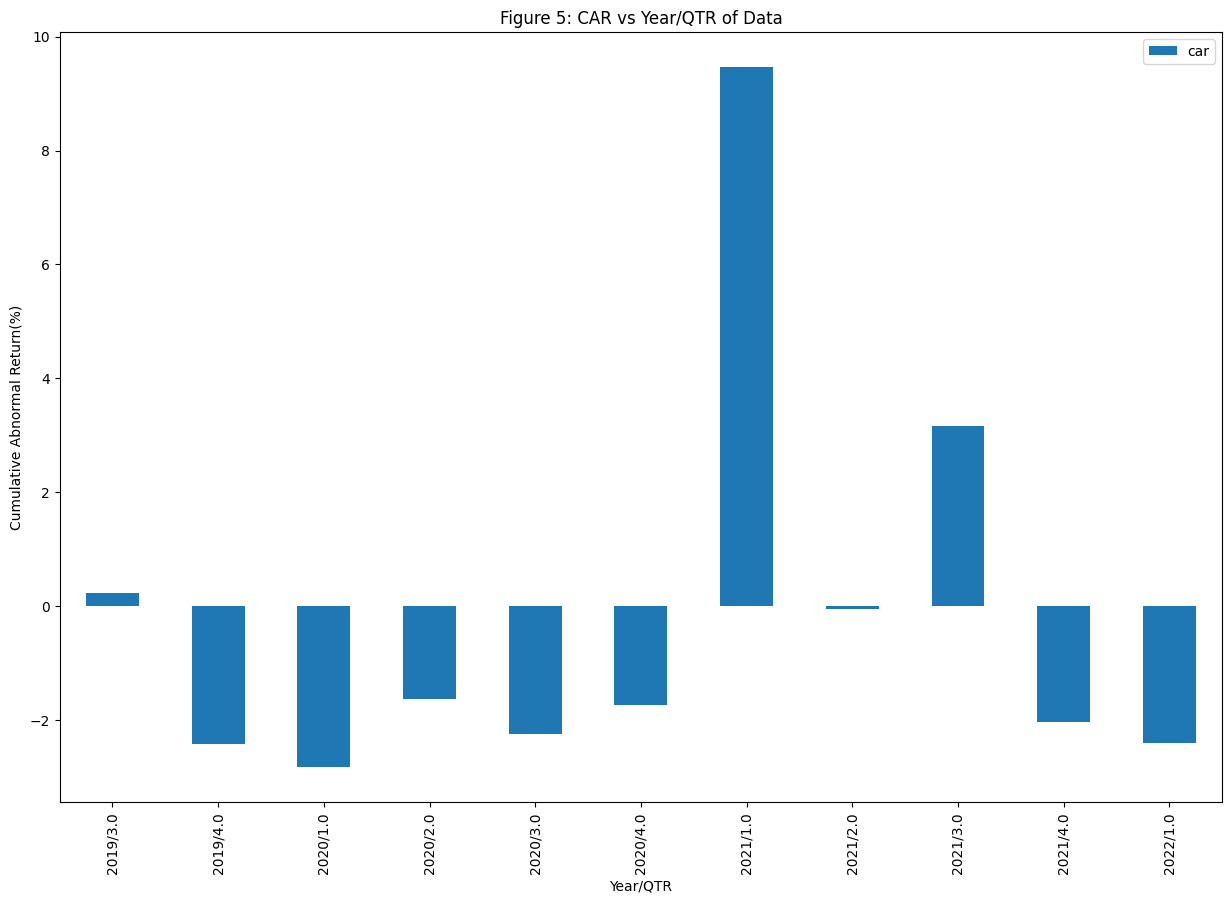

In [ ]:
#Replicate figure 5

car60dHiLoWithDates['year'] = car60dHiLoWithDates['date'].dt.year
car60dHiLoWithDates['qtr'] = np.ceil(car60dHiLoWithDates['date'].dt.month/3)
car60dHiLoWithDates['year/qtr'] = car60dHiLoWithDates['year'].apply(str) + "/" + car60dHiLoWithDates['qtr'].apply(str)

car60dHiLoWithDates = car60dHiLoWithDates[car60dHiLoWithDates['days_after_rdq'] == 60]
car60dGroupedByYearQtr = car60dHiLoWithDates.groupby('year/qtr', as_index = False)['car'].mean()

plotCAR60dByYearQtr = car60dGroupedByYearQtr.plot(x = 'year/qtr', y = ['car'], kind="bar", figsize=[15,10], title = "Figure 5: CAR vs Year/QTR of Data")
plotCAR60dByYearQtr.set_xlabel("Year/QTR")
plotCAR60dByYearQtr.set_ylabel("Cumulative Abnormal Return(%)")

fig = plotCAR60dByYearQtr.get_figure()
fig.savefig(filePath + "/plotCAR60dByYearQtr.png")

In [ ]:
#Generate Dataframes for Each portfolios Again for Raw Returns INstead of CAR
mainDF = originalMain
mainDFLo = mainDF[mainDF['sue_decile'] == 1]
mainDFLoSmall = mainDFLo[mainDFLo['size_decile'] <= 4]
mainDFLoMed = mainDFLo[(mainDFLo['size_decile'] >= 5) & (mainDFLo['size_decile'] <= 7)]
mainDFLoBig = mainDFLo[mainDFLo['size_decile'] >= 8]
mainDFHi = mainDF[mainDF['sue_decile'] == 10]
mainDFHiSmall = mainDFHi[mainDFHi['size_decile'] <= 4]
mainDFHiMed = mainDFHi[(mainDFHi['size_decile'] >= 5) & (mainDFHi['size_decile'] <= 7)]
mainDFHiBig = mainDFHi[mainDFHi['size_decile'] >= 8]

#Generate TicOfRDQ and raw return dataframees for each portfolio
#S/L
ticOfRDQLoSmall = mainDFLoSmall.dropna()
ticOfRDQLoSmall = ticOfRDQLoSmall.filter(['tic', 'sue_decile', 'size_decile'])
rawRetLoSmall = mainDF.reset_index()
rawRetLoSmall.columns = ['original_index', 'tic', 'date', 'datadate', 'year', 'qtr', 'ret', 'rdq', 'size_decile', 'avg_ret', 'abn_ret', 'sue', 'sue_decile']
rawRetLoSmall['new_index'] = rawRetLoSmall['tic'].apply(str) + "/" + rawRetLoSmall['original_index'].apply(str)
rawRetLoSmall = rawRetLoSmall.set_index('new_index')

#M/L
ticOfRDQLoMed = mainDFLoMed.dropna()
ticOfRDQLoMed = ticOfRDQLoMed.filter(['tic', 'sue_decile', 'size_decile'])
rawRetLoMed = mainDF.reset_index()
rawRetLoMed.columns = ['original_index', 'tic', 'date', 'datadate', 'year', 'qtr', 'ret', 'rdq', 'size_decile', 'avg_ret', 'abn_ret', 'sue', 'sue_decile']
rawRetLoMed['new_index'] = rawRetLoMed['tic'].apply(str) + "/" + rawRetLoMed['original_index'].apply(str)
rawRetLoMed = rawRetLoMed.set_index('new_index')

#B/L
ticOfRDQLoBig = mainDFLoBig.dropna()
ticOfRDQLoBig = ticOfRDQLoBig.filter(['tic', 'sue_decile', 'size_decile'])
rawRetLoBig = mainDF.reset_index()
rawRetLoBig.columns = ['original_index', 'tic', 'date', 'datadate', 'year', 'qtr', 'ret', 'rdq', 'size_decile', 'avg_ret', 'abn_ret', 'sue', 'sue_decile']
rawRetLoBig['new_index'] = rawRetLoBig['tic'].apply(str) + "/" + rawRetLoBig['original_index'].apply(str)
rawRetLoBig = rawRetLoBig.set_index('new_index')

#S/H
ticOfRDQHiSmall = mainDFHiSmall.dropna()
ticOfRDQHiSmall = ticOfRDQHiSmall.filter(['tic', 'sue_decile', 'size_decile'])
rawRetHiSmall = mainDF.reset_index()
rawRetHiSmall.columns = ['original_index', 'tic', 'date', 'datadate', 'year', 'qtr', 'ret', 'rdq', 'size_decile', 'avg_ret', 'abn_ret', 'sue', 'sue_decile']
rawRetHiSmall['new_index'] = rawRetHiSmall['tic'].apply(str) + "/" + rawRetHiSmall['original_index'].apply(str)
rawRetHiSmall = rawRetHiSmall.set_index('new_index')

#M/H
ticOfRDQHiMed = mainDFHiMed.dropna()
ticOfRDQHiMed = ticOfRDQHiMed.filter(['tic', 'sue_decile', 'size_decile'])
rawRetHiMed = mainDF.reset_index()
rawRetHiMed.columns = ['original_index', 'tic', 'date', 'datadate', 'year', 'qtr', 'ret', 'rdq', 'size_decile', 'avg_ret', 'abn_ret', 'sue', 'sue_decile']
rawRetHiMed['new_index'] = rawRetHiMed['tic'].apply(str) + "/" + rawRetHiMed['original_index'].apply(str)
rawRetHiMed = rawRetHiMed.set_index('new_index')

#B/H
ticOfRDQHiBig = mainDFHiBig.dropna()
ticOfRDQHiBig = ticOfRDQHiBig.filter(['tic', 'sue_decile', 'size_decile'])
rawRetHiBig = mainDF.reset_index()
rawRetHiBig.columns = ['original_index', 'tic', 'date', 'datadate', 'year', 'qtr', 'ret', 'rdq', 'size_decile', 'avg_ret', 'abn_ret', 'sue', 'sue_decile']
rawRetHiBig['new_index'] = rawRetHiBig['tic'].apply(str) + "/" + rawRetHiBig['original_index'].apply(str)
rawRetHiBig = rawRetHiBig.set_index('new_index')

#Starting and ending days of periods to calculate raw returns
startingDays = [1, 6, 21, 41, 61]
endingDays = [5, 20, 40, 60, 80]

#Fill new dataframe with empty arrays to get CRR for S/L portfolio
avgCRRLoSmall = pd.DataFrame(index = startingDays, columns = ['crr'])
for i in avgCRRLoSmall.index:
  for j in avgCRRLoSmall.columns:
    avgCRRLoSmall[j][i] = []

#Fill new dataframe with cumulative raw return (CRR) data
for i in range(len(startingDays)):
  a = startingDays[i]
  b = endingDays[i]
  for rdqDate in ticOfRDQLoSmall.index:
    #Generate indices for abnormal return dataframe
    startIndex = str(ticOfRDQLoSmall['tic'][rdqDate]) + "/" + str(rdqDate + a)
    endIndex = str(ticOfRDQLoSmall['tic'][rdqDate]) + "/" + str(rdqDate + b)
    if (startIndex in rawRetLoSmall.index) and (endIndex in rawRetLoSmall.index):
      periodDF = pd.DataFrame(rawRetLoSmall.loc[startIndex : endIndex]).reset_index()
      periodDF['crr'] = periodDF['ret'].cumsum()
      avgCRRLoSmall['crr'][a].append(periodDF['crr'][b - a])

#Take averages of each array to get average CRR on final day
for i in avgCRRLoSmall.index:
  avgCRRLoSmall['crr'][i] = np.average(avgCRRLoSmall['crr'][i]) * 100

#Repeat for Every Portfolio
#M/L
avgCRRLoMed = pd.DataFrame(index = startingDays, columns = ['crr'])
for i in avgCRRLoMed.index:
  for j in avgCRRLoMed.columns:
    avgCRRLoMed[j][i] = []

for i in range(len(startingDays)):
  a = startingDays[i]
  b = endingDays[i]
  for rdqDate in ticOfRDQLoMed.index:
    startIndex = str(ticOfRDQLoMed['tic'][rdqDate]) + "/" + str(rdqDate + a)
    endIndex = str(ticOfRDQLoMed['tic'][rdqDate]) + "/" + str(rdqDate + b)
    if (startIndex in rawRetLoMed.index) and (endIndex in rawRetLoMed.index):
      periodDF = pd.DataFrame(rawRetLoMed.loc[startIndex : endIndex]).reset_index()
      periodDF['crr'] = periodDF['ret'].cumsum()
      avgCRRLoMed['crr'][a].append(periodDF['crr'][b - a])

for i in avgCRRLoMed.index:
  avgCRRLoMed['crr'][i] = np.average(avgCRRLoMed['crr'][i]) * 100

#B/L
avgCRRLoBig = pd.DataFrame(index = startingDays, columns = ['crr'])
for i in avgCRRLoBig.index:
  for j in avgCRRLoBig.columns:
    avgCRRLoBig[j][i] = []

for i in range(len(startingDays)):
  a = startingDays[i]
  b = endingDays[i]
  for rdqDate in ticOfRDQLoBig.index:
    startIndex = str(ticOfRDQLoBig['tic'][rdqDate]) + "/" + str(rdqDate + a)
    endIndex = str(ticOfRDQLoBig['tic'][rdqDate]) + "/" + str(rdqDate + b)
    if (startIndex in rawRetLoBig.index) and (endIndex in rawRetLoBig.index):
      periodDF = pd.DataFrame(rawRetLoBig.loc[startIndex : endIndex]).reset_index()
      periodDF['crr'] = periodDF['ret'].cumsum()
      avgCRRLoBig['crr'][a].append(periodDF['crr'][b - a])

for i in avgCRRLoBig.index:
  avgCRRLoBig['crr'][i] = np.average(avgCRRLoBig['crr'][i]) * 100

#S/H
avgCRRHiSmall = pd.DataFrame(index = startingDays, columns = ['crr'])
for i in avgCRRHiSmall.index:
  for j in avgCRRHiSmall.columns:
    avgCRRHiSmall[j][i] = []

for i in range(len(startingDays)):
  a = startingDays[i]
  b = endingDays[i]
  for rdqDate in ticOfRDQHiSmall.index:
    startIndex = str(ticOfRDQHiSmall['tic'][rdqDate]) + "/" + str(rdqDate + a)
    endIndex = str(ticOfRDQHiSmall['tic'][rdqDate]) + "/" + str(rdqDate + b)
    if (startIndex in rawRetHiSmall.index) and (endIndex in rawRetHiSmall.index):
      periodDF = pd.DataFrame(rawRetHiSmall.loc[startIndex : endIndex]).reset_index()
      periodDF['crr'] = periodDF['ret'].cumsum()
      avgCRRHiSmall['crr'][a].append(periodDF['crr'][b - a])

for i in avgCRRHiSmall.index:
  avgCRRHiSmall['crr'][i] = np.average(avgCRRHiSmall['crr'][i]) * 100

#M/H
avgCRRHiMed = pd.DataFrame(index = startingDays, columns = ['crr'])
for i in avgCRRHiMed.index:
  for j in avgCRRHiMed.columns:
    avgCRRHiMed[j][i] = []

for i in range(len(startingDays)):
  a = startingDays[i]
  b = endingDays[i]
  for rdqDate in ticOfRDQHiMed.index:
    startIndex = str(ticOfRDQHiMed['tic'][rdqDate]) + "/" + str(rdqDate + a)
    endIndex = str(ticOfRDQHiMed['tic'][rdqDate]) + "/" + str(rdqDate + b)
    if (startIndex in rawRetHiMed.index) and (endIndex in rawRetHiMed.index):
      periodDF = pd.DataFrame(rawRetHiMed.loc[startIndex : endIndex]).reset_index()
      periodDF['crr'] = periodDF['ret'].cumsum()
      avgCRRHiMed['crr'][a].append(periodDF['crr'][b - a])

for i in avgCRRHiMed.index:
  avgCRRHiMed['crr'][i] = np.average(avgCRRHiMed['crr'][i]) * 100

#B/H
avgCRRHiBig = pd.DataFrame(index = startingDays, columns = ['crr'])
for i in avgCRRHiBig.index:
  for j in avgCRRHiBig.columns:
    avgCRRHiBig[j][i] = []

for i in range(len(startingDays)):
  a = startingDays[i]
  b = endingDays[i]
  for rdqDate in ticOfRDQHiBig.index:
    startIndex = str(ticOfRDQHiBig['tic'][rdqDate]) + "/" + str(rdqDate + a)
    endIndex = str(ticOfRDQHiBig['tic'][rdqDate]) + "/" + str(rdqDate + b)
    if (startIndex in rawRetHiBig.index) and (endIndex in rawRetHiBig.index):
      periodDF = pd.DataFrame(rawRetHiBig.loc[startIndex : endIndex]).reset_index()
      periodDF['crr'] = periodDF['ret'].cumsum()
      avgCRRHiBig['crr'][a].append(periodDF['crr'][b - a])

for i in avgCRRHiBig.index:
  avgCRRHiBig['crr'][i] = np.average(avgCRRHiBig['crr'][i]) * 100

print(avgCRRLoSmall)
print(avgCRRLoMed)
print(avgCRRLoBig)
print(avgCRRHiSmall)
print(avgCRRHiMed)
print(avgCRRHiBig)

         crr
1  -1.769781
6   1.274562
21  2.839626
41  4.965631
61  0.493371
         crr
1  -2.210137
6   3.102147
21  0.516394
41  2.376906
61  0.450262
         crr
1  -1.003209
6  -0.605426
21   1.27234
41  2.513633
61  2.168169
         crr
1   3.158258
6   1.071449
21  0.862913
41  4.394104
61  3.995017
         crr
1   1.389746
6   1.048385
21  0.495416
41  3.593268
61   3.65969
         crr
1   1.544914
6   1.150487
21 -0.557461
41  3.561169
61  1.973681


In [ ]:
#Replicate Table 4

table4A = pd.DataFrame(index = startingDays)
table4A['postannouncement_period'] = ['(1, 5)', '(6, 20)', '(21, 40)', '(41, 60)', '(61, 80)']
table4A['s/l_rr'] = avgCRRLoSmall['crr']
table4A['s/l_crr'] = table4A['s/l_rr'].cumsum()
table4A['m/l_rr'] = avgCRRLoMed['crr']
table4A['m/l_crr'] = table4A['m/l_rr'].cumsum()
table4A['b/l_rr'] = avgCRRLoBig['crr']
table4A['b/l_crr'] = table4A['b/l_rr'].cumsum()

table4B = pd.DataFrame(index = startingDays)
table4B['postannouncement_period'] = ['(1, 5)', '(1, 20)', '(1, 40)', '(1, 60)', '(1, 80)']

table4B['s/l_crr_annualized'] = ""
table4B['s/l_crr_annualized'][1] = table4A['s/l_crr'][1] * 252 / 5
table4B['s/l_crr_annualized'][6] = table4A['s/l_crr'][6] * 252 / 20
table4B['s/l_crr_annualized'][21] = table4A['s/l_crr'][21] * 252 / 40
table4B['s/l_crr_annualized'][41] = table4A['s/l_crr'][41] * 252 / 60
table4B['s/l_crr_annualized'][61] = table4A['s/l_crr'][61] * 252 / 80

table4B['m/l_crr_annualized'] = ""
table4B['m/l_crr_annualized'][1] = table4A['m/l_crr'][1] * 252 / 5
table4B['m/l_crr_annualized'][6] = table4A['m/l_crr'][6] * 252 / 20
table4B['m/l_crr_annualized'][21] = table4A['m/l_crr'][21] * 252 / 40
table4B['m/l_crr_annualized'][41] = table4A['m/l_crr'][41] * 252 / 60
table4B['m/l_crr_annualized'][61] = table4A['m/l_crr'][61] * 252 / 80

table4B['b/l_crr_annualized'] = ""
table4B['b/l_crr_annualized'][1] = table4A['b/l_crr'][1] * 252 / 5
table4B['b/l_crr_annualized'][6] = table4A['b/l_crr'][6] * 252 / 20
table4B['b/l_crr_annualized'][21] = table4A['b/l_crr'][21] * 252 / 40
table4B['b/l_crr_annualized'][41] = table4A['b/l_crr'][41] * 252 / 60
table4B['b/l_crr_annualized'][61] = table4A['b/l_crr'][61] * 252 / 80

table4B['s/h_crr_annualized'] = ""
table4B['s/h_crr_annualized'] = avgCRRHiSmall.cumsum()
table4B['s/h_crr_annualized'][1] *= 252 / 5
table4B['s/h_crr_annualized'][6] *= 252 / 20
table4B['s/h_crr_annualized'][21] *= 252 / 40
table4B['s/h_crr_annualized'][41] *= 252 / 60
table4B['s/h_crr_annualized'][61] *= 252 / 80

table4B['m/h_crr_annualized'] = ""
table4B['m/h_crr_annualized'] = avgCRRHiMed.cumsum()
table4B['m/h_crr_annualized'][1] *= 252 / 5
table4B['m/h_crr_annualized'][6] *= 252 / 20
table4B['m/h_crr_annualized'][21] *= 252 / 40
table4B['m/h_crr_annualized'][41] *= 252 / 60
table4B['m/h_crr_annualized'][61] *= 252 / 80

table4B['b/h_crr_annualized'] = ""
table4B['b/h_crr_annualized'] = avgCRRHiBig.cumsum()
table4B['b/h_crr_annualized'][1] *= 252 / 5
table4B['b/h_crr_annualized'][6] *= 252 / 20
table4B['b/h_crr_annualized'][21] *= 252 / 40
table4B['b/h_crr_annualized'][41] *= 252 / 60
table4B['b/h_crr_annualized'][61] *= 252 / 80

table4B['low_avg'] = table4B.iloc[:, 1:4].mean(axis = 1)
table4B['high_avg'] = table4B.iloc[:, 4:7].mean(axis = 1)
print(table4A)
print(table4B)

   postannouncement_period    s/l_rr   s/l_crr    m/l_rr   m/l_crr    b/l_rr  \
1                   (1, 5) -1.769781 -1.769781 -2.210137 -2.210137 -1.003209   
6                  (6, 20)  1.274562 -0.495219  3.102147  0.892009 -0.605426   
21                (21, 40)  2.839626  2.344407  0.516394  1.408403   1.27234   
41                (41, 60)  4.965631  7.310038  2.376906  3.785309  2.513633   
61                (61, 80)  0.493371  7.803409  0.450262  4.235571  2.168169   

     b/l_crr  
1  -1.003209  
6  -1.608635  
21 -0.336295  
41  2.177339  
61  4.345508  
   postannouncement_period s/l_crr_annualized m/l_crr_annualized  \
1                   (1, 5)         -89.196966        -111.390924   
6                  (1, 20)          -6.239754          11.239315   
21                 (1, 40)          14.769767           8.872942   
41                 (1, 60)          30.702161          15.898298   
61                 (1, 80)          24.580738           13.34205   

   b/l_crr_annualize

In [ ]:
#Replicate Table 2

mainDF = originalMain

#Add treasury bills (r_f) and equuity risk (r_m - r_f) to mainDF
mainDF.to_sql("mainDF", conn, if_exists = 'replace')
ffDF.to_sql("ffDF", conn, if_exists = 'replace')
query = '''
        SELECT DISTINCT mainDF.*, ffDF.rm_minus_rf, ffDF.rf
        FROM mainDF
        LEFT JOIN ffDF
        ON mainDF.date = ffDF.date
        '''
mainDF = pd.read_sql(query, conn)

#Convert FF data to decimal
mainDF['rm_minus_rf'] /= 100
mainDF['rf'] /= 100
mainDF.drop('index', inplace = True, axis = 1)

#Create starting days and ending days arrays
startingDays = [-119, -59, 1, 61, 121, 181]
endingDays = [-60, 0, 60, 120, 180, 240]

#Define new function to calculate compounded total returns
def calculateCumRawRetCompounded(startingDay, endingDay, ticsToAnalyze):
  cumRetMinusCumRF = []
  cumRMMinusRF = []
  for i in ticsToAnalyze.index:
    #Generate indices for abnormal return dataframes
    startIndex = i + startingDay
    endIndex = i + endingDay
    if((startIndex in mainDF.index) and (mainDF['tic'][startIndex]) == ticsToAnalyze['tic'][i]) and ((endIndex in mainDF.index) and(mainDF['tic'][endIndex] == ticsToAnalyze['tic'][i])):
      retWindowDF = pd.DataFrame(mainDF.loc[startIndex : endIndex]).reset_index()
      retWindowDF['cum_ret'] = (1 + retWindowDF['ret']).cumprod() - 1
      retWindowDF['cum_rm_minus_rf'] = (1 + retWindowDF['rm_minus_rf']).cumprod() - 1
      retWindowDF['cum_rf'] = (1 + retWindowDF['rf']).cumprod() - 1
      cumRetMinusCumRF.append(retWindowDF['cum_ret'][endingDay - startingDay] - retWindowDF['cum_rf'][b - a])
      cumRMMinusRF.append(retWindowDF['cum_rm_minus_rf'][endingDay - startingDay])

  resultsDF = pd.DataFrame()
  resultsDF['cum_ret_minus_cum_rf'] = cumRetMinusCumRF
  resultsDF['cum_rm_minus_rf'] = cumRMMinusRF
  return resultsDF

#Run regressions for each decile on each period
for j in range(1, 11):
  currentTicsToAnalyze = TicOfRDQ[TicOfRDQ['sue_decile'] == j]
  for k in range(len(startingDays)):
    dfForTable2Reg = calculateCumRawRetCompounded(startingDays[k], endingDays[k], currentTicsToAnalyze)
    tempReg = sm.ols("cum_ret_minus_cum_rf ~ cum_rm_minus_rf", data = dfForTable2Reg).fit()
    tempRegSummary = tempReg.summary()
    print("Decile = " + str(j) + "; starting day of period " + str(startingDays[k]) + ":")
    print(tempRegSummary)

Decile = 1; starting day of period -119:
                             OLS Regression Results                             
Dep. Variable:     cum_ret_minus_cum_rf   R-squared:                       0.093
Model:                              OLS   Adj. R-squared:                  0.093
Method:                   Least Squares   F-statistic:                     124.6
Date:                  Mon, 10 Apr 2023   Prob (F-statistic):           1.32e-27
Time:                          23:59:43   Log-Likelihood:                -671.25
No. Observations:                  1213   AIC:                             1346.
Df Residuals:                      1211   BIC:                             1357.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

In [ ]:
## Find Rank Correlation
file = filePath + "/Table_2A.csv"
table2A = pd.read_csv(file)

#Spearman Rank Correlation Test
for i in table2A.columns:
  print(stats.spearmanr(table2A['sue_decile'], table2A[i]))


FileNotFoundError: ignored